In [1]:
import os
import os.path as osp
import string
import glob
import json

import numpy as np

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

plt.style.use("default")
plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 10
})

class_names = {"kitti": ["car", "van", "truck", "pedestrian",
                         "person", "cyclist", "tram", "misc"],
               "mnist_det_active": [str(x) for x in range(10)],
               "emnist_det_active": list(string.ascii_uppercase),
               "voc": ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
                       'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
                       'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
                       'tvmonitor')}

class_exceptions = {"kitti": ["person"],
                    "mnist_det_active": [],
                    "emnist_det_active": [],
                    "voc": [],
                    }
max_performance = {
    "retinanet":
        {
            "mnist_det_active": 0.867,
            "emnist_det_active": 0.833
        },
    "yolov3":
        {
            "mnist_det_active": 0.965,
            "emnist_det_active": 0.965,
            "voc": 0.7942500000000001
        },
    "faster_rcnn":
        {
            "voc": 0.79725
        }
}

mpl_colors = list(mcolors.TABLEAU_COLORS.values())
mpl_linestyles = ["solid", "dotted", "dashed", "dashdot"]

method_labels = {
    "core": "Core Set",
    "dropout": "MC Dropout",
    "entropy": "Entropy",
    "meta_detect": "MetaDetect",
    "mutual_information": "MC Mutual Information",
    "prob_margin": "Probability Margin",
    "random": "Random"
}

metric_labels = {
    'bbox_mAP_50': "$AP_{50}$"
}

scale_labels = {
    'num_boxes': "$\# boxes$"
}

def plot_comparison(path, methods, runs=None, plot_ylimits=None, x_scale=None, metric='bbox_mAP_50', bands=True, arch="retinanet", dataset="mnist_det_active", labels=None, max_steps=16):
    max_num_steps = 0
    for i_meth, m in enumerate(methods):
        if not runs:
            num_runs = len(glob.glob(osp.join(path, m, "run_*")))
            # improve run picks.
            runs = range(num_runs)
            num_steps = min([len(glob.glob(osp.join(path, m, f"run_{i}", "step_*"))) for i in range(num_runs)]+[max_steps])
        else:
            num_runs = len(runs[i_meth])
            num_steps = min([len(glob.glob(osp.join(path, m, f"run_{i}", "step_*"))) for i in runs[i_meth]]+[max_steps])
        # print(num_steps)
        x_range = []
        for i in runs[i_meth]:
            if not osp.exists(osp.join(path, m, f"run_{i}", f"step_{num_steps-1}", "test_map.json")):
                # print(num_steps, osp.join(path, m, f"run_{i}", f"step_{num_steps-1}", "test_map.json"))
                num_steps -= 1
                # print(num_steps)
                break
        # print(num_runs, num_steps)
        perf = np.zeros((num_runs, num_steps))
        for i_run, r in enumerate(runs[i_meth]):
            for i_step in range(num_steps):
                eval_ls = glob.glob(osp.join(path, m, f"run_{r}", f"step_{i_step}", "eval_*.json"))
                if len(eval_ls) > 0:
                    d = json.load(open(eval_ls[-1], "r"))
                    perf[i_run, i_step] = d["metric"][metric]
                else:
                    d = json.load(open(osp.join(path, m, f"run_{r}", f"step_{i_step}", "test_map.json"), "r"))
                    perf[i_run, i_step] = d[metric]
                if i_run == 0:
                    if x_scale is None:
                        x_range.append(i_step)
                        plt.xlabel("steps")
                    elif x_scale == "num_images":
                        scale_d = json.load(open(osp.join(path, m, f"run_{r}", f"step_{i_step}", "labeled_data.json"), "r"))
                        x_range.append(len(scale_d["ds_indices"]))
                        plt.xlabel("\# images")
                    elif x_scale == "num_boxes":
                    #     scale_d = json.load(open(osp.join(path, m, f"run_{r}", f"step_{i_step}", "labeled_anns.json"), "r"))
                    #     x_range.append(len(scale_d["annotations"]))
                        plt.xlabel("\# boxes")
                if x_scale == "num_boxes":
                    if i_step == 0:
                        x_range.append([])
                    scale_d = json.load(open(osp.join(path, m, f"run_{r}", f"step_{i_step}", "labeled_anns.json"), "r"))
                    x_range[i_run].append(len(scale_d["annotations"]))
        if x_scale == "num_boxes":
            # from sklearn.linear_model import BayesianRidge
            # perf = np.array(perf).flatten()
            # mod = BayesianRidge(n_iter=5000, tol=1e-6, alpha_init=1.0, lambda_init=1e-3, fit_intercept=False, compute_score=True).fit(np.repeat(np.array(x_range), len(runs[i_meth])).reshape(-1, 1), perf)
            # x_range = np.linspace(0, max_num_steps, num=max_num_steps//5)
            # mean_perf, std_perf = mod.predict(x_range.reshape(-1, 1), return_std=True)
            models = []
            from sklearn.neighbors import KNeighborsRegressor
            min_max_x_range = x_range[-1][-1]
            max_min_x_range = x_range[-1][0]
            for i_curve, x in enumerate(x_range):
                # print(np.array(x).resize(-1, 1))
                # print(perf[i_curve])
                m = KNeighborsRegressor(n_neighbors=2, weights='distance').fit(np.array(x).reshape(-1, 1), perf[i_curve])
                models.append(m)
                min_max_x_range = min(min_max_x_range, x[-1])
                max_min_x_range = max(max_min_x_range, x[0])
            x_range = np.linspace(max_min_x_range, min_max_x_range, 10000)
            perf = np.array([m.predict(x_range.reshape(-1, 1)) for m in models])
        mean_perf = np.mean(perf, axis=0)
        std_perf = np.std(perf, axis=0)
        if x_range[-1] > max_num_steps:
            max_num_steps = x_range[-1]

        if labels is None:
            l = method_labels[m]+str(runs[i_meth])
        else:
            l = labels[i_meth]

        plt.plot(x_range, mean_perf, label=l)
        if bands:
            plt.fill_between(x_range, mean_perf-std_perf, mean_perf+std_perf, alpha=0.5)
    if plot_ylimits:
        plt.ylim(plot_ylimits)

    ### max mAP lines

    if arch in max_performance and dataset in max_performance[arch]:
        max_perf = max_performance[arch][dataset]
        plt.plot([0, max_num_steps-1],
                 [max_perf, max_perf], color="gray", linewidth=2)
        plt.text(max_num_steps, max_perf -
                 0.009, "$100 \\%$", color="gray")
        plt.plot([0, max_num_steps-1],
                 [0.85*max_perf, 0.85*max_perf], color="green", linewidth=1, linestyle="--")
        plt.text(max_num_steps, 0.85*max_perf -
                 0.009, "$85 \\%$", color="green")
        plt.text(max_num_steps, 0.90*max_perf -
                 0.009, "$90 \\%$", color="orange")
        plt.text(max_num_steps, 0.95*max_perf -
                 0.009, "$95 \\%$", color="red")
        plt.plot([0, max_num_steps-1],
                 [0.9*max_perf, 0.9*max_perf], color="orange", linewidth=1, linestyle="--")
        plt.plot([0, max_num_steps-1],
                 [0.95*max_perf, 0.95*max_perf], color="red", linewidth=1, linestyle="--")
    
    plt.legend()
    plt.grid(True)
    plt.ylabel(metric_labels[metric])
    # plt.show()


# MNIST Entropy baselines

15
15
15
15


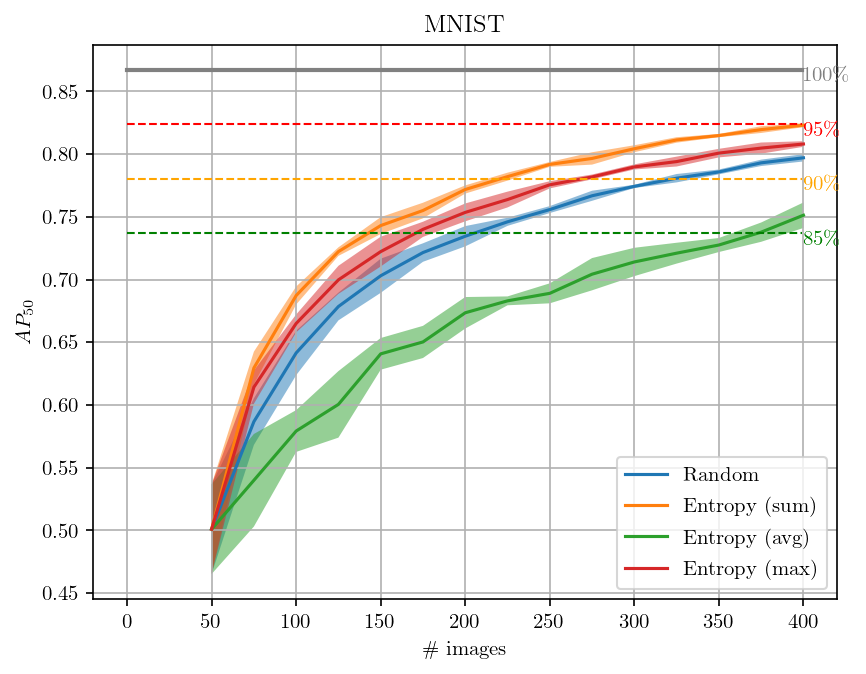

In [4]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "entropy", "entropy", "entropy"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "Entropy (sum)", "Entropy (avg)", "Entropy (max)"],
                dataset="mnist_det_active", 
                x_scale="num_images",
                max_steps=15)

15
15
15
15


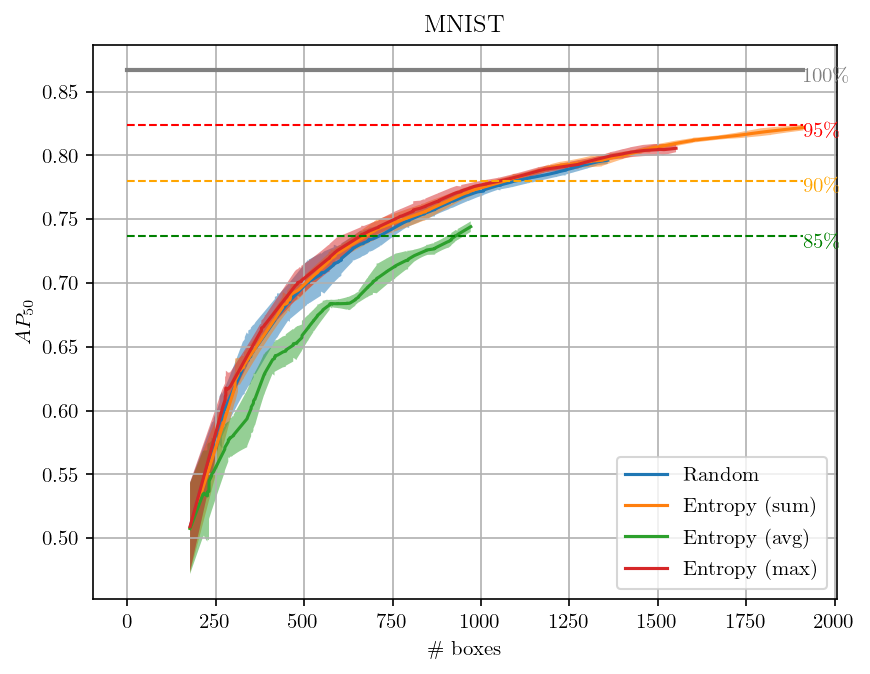

In [100]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "entropy", "entropy", "entropy"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "Entropy (sum)", "Entropy (avg)", "Entropy (max)"],
                dataset="mnist_det_active", 
                x_scale="num_boxes",
                max_steps=15)

# MNIST Probability Margin baselines

15
15
15
15


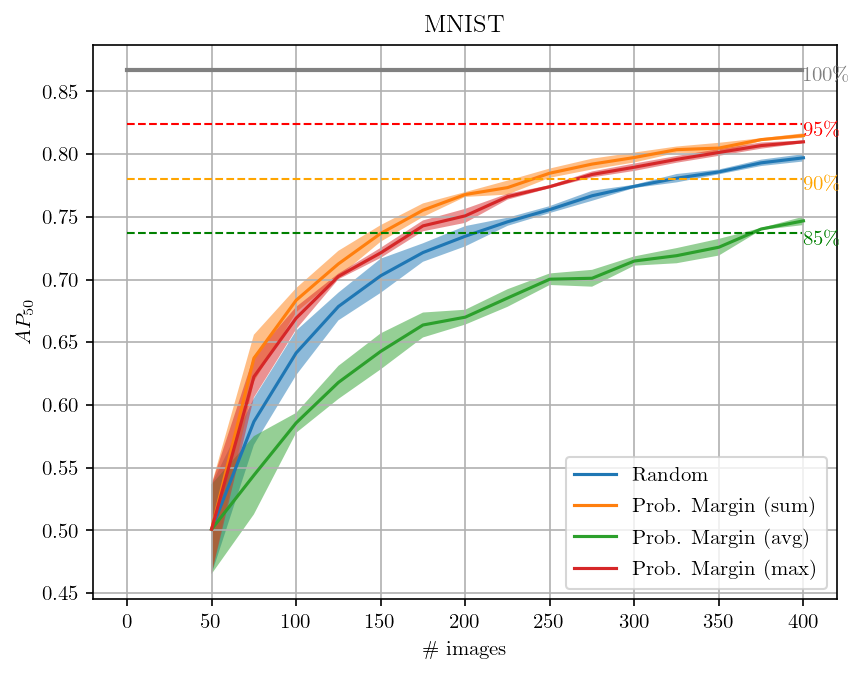

In [7]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "prob_margin", "prob_margin", "prob_margin"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "Prob. Margin (sum)", "Prob. Margin (avg)", "Prob. Margin (max)"],
                dataset="mnist_det_active", 
                x_scale="num_images",
                max_steps=15)

15
15
15
15


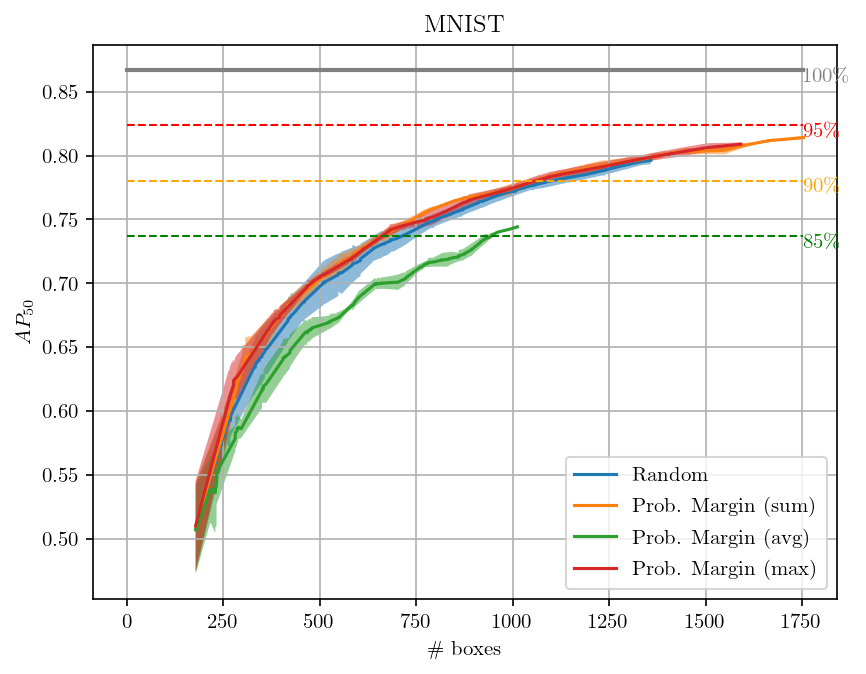

In [102]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "prob_margin", "prob_margin", "prob_margin"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "Prob. Margin (sum)", "Prob. Margin (avg)", "Prob. Margin (max)"],
                dataset="mnist_det_active", 
                x_scale="num_boxes",
                max_steps=15)

# MNIST Mutual Information baselines

15
15
15
15


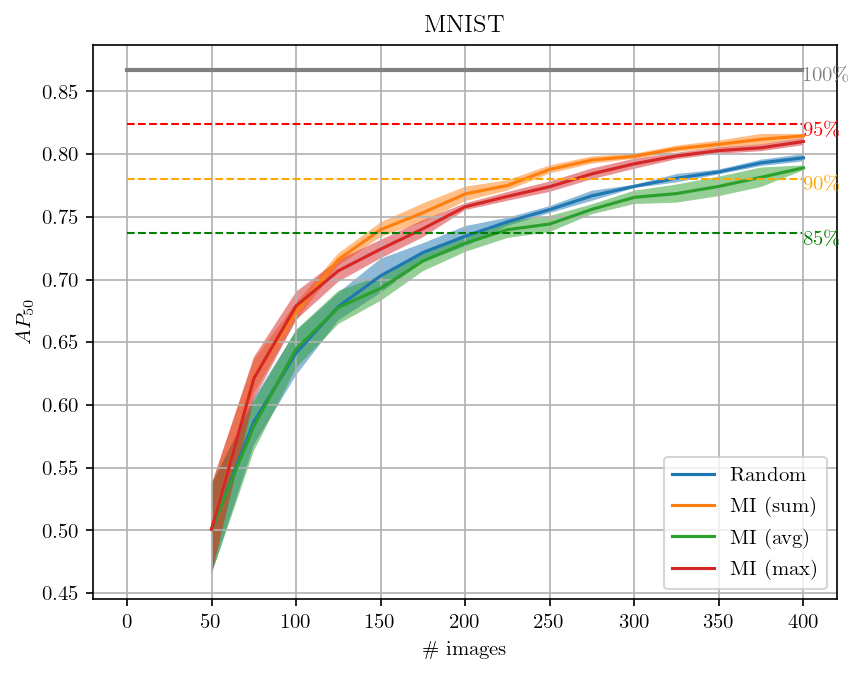

In [10]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "mutual_information", "mutual_information", "mutual_information"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "MI (sum)", "MI (avg)", "MI (max)"],
                dataset="mnist_det_active", 
                x_scale="num_images",
                max_steps=15)

15
15
15
15


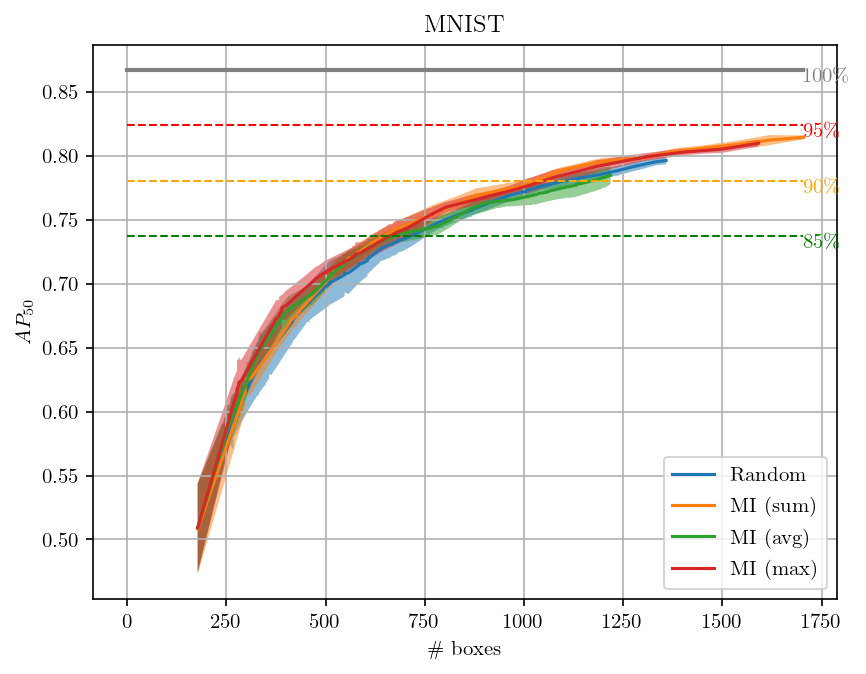

In [103]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "mutual_information", "mutual_information", "mutual_information"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "MI (sum)", "MI (avg)", "MI (max)"],
                dataset="mnist_det_active", 
                x_scale="num_boxes",
                max_steps=15)

# MNIST Dropout baselines

15
15
15
15


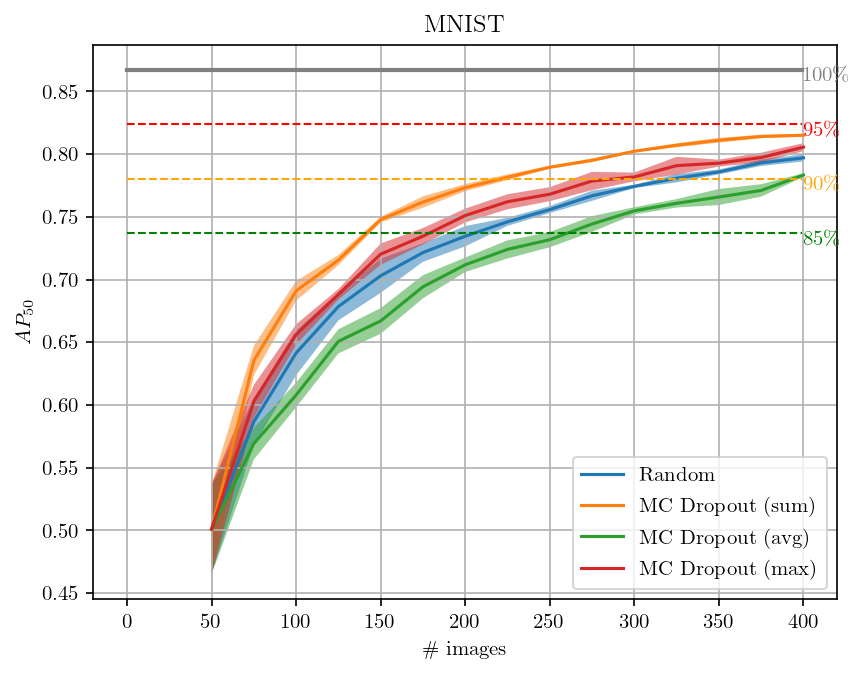

In [12]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "dropout", "dropout", "dropout"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "MC Dropout (sum)", "MC Dropout (avg)", "MC Dropout (max)"],
                dataset="mnist_det_active", 
                x_scale="num_images",
                max_steps=15)

15
15
15
15


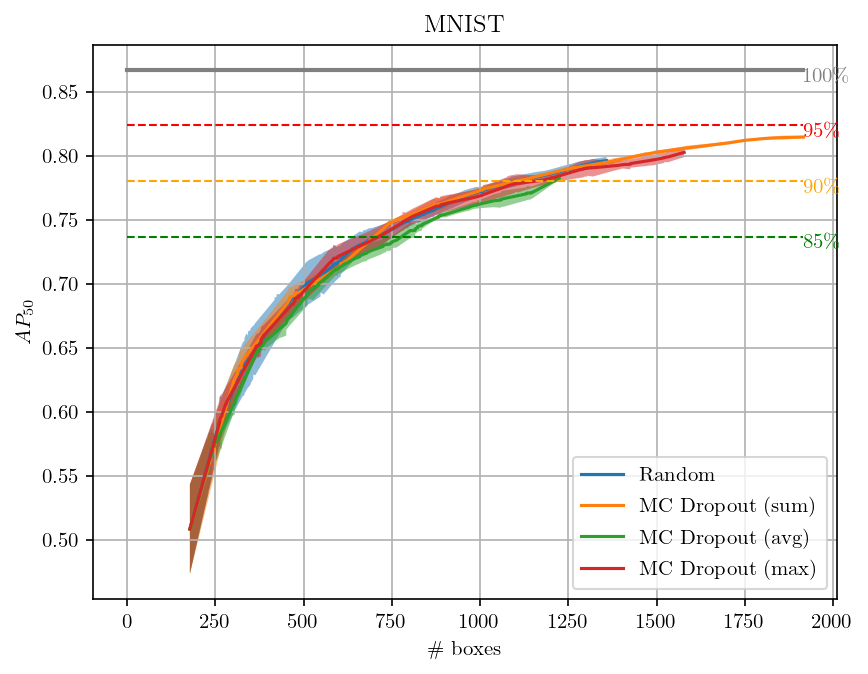

In [104]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "dropout", "dropout", "dropout"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "MC Dropout (sum)", "MC Dropout (avg)", "MC Dropout (max)"],
                dataset="mnist_det_active", 
                x_scale="num_boxes",
                max_steps=15)

# MNIST Core Set baselines

15
15


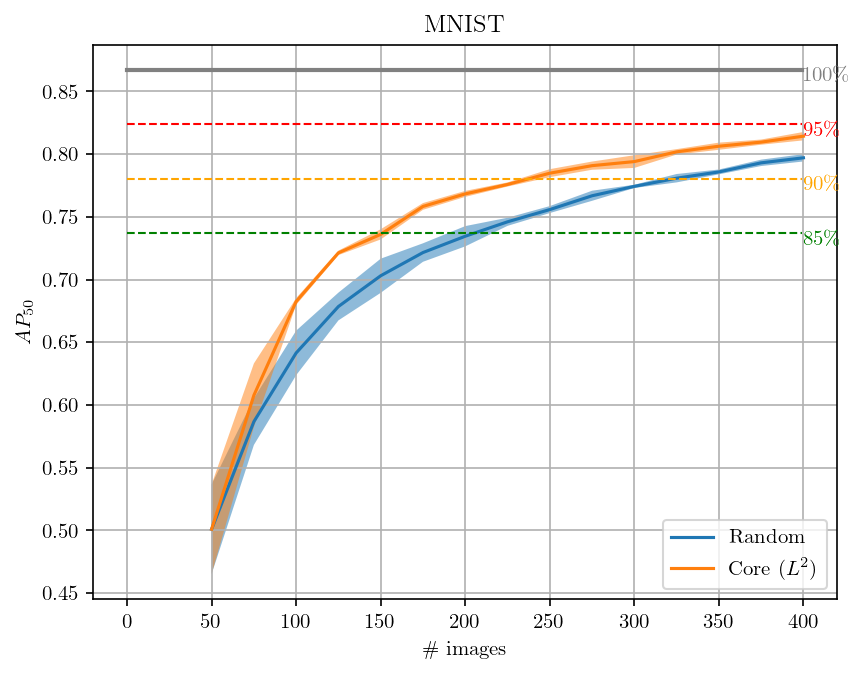

In [15]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "core"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3]],
                labels = ["Random", "Core ($L^2$)"],
                dataset="mnist_det_active", 
                x_scale="num_images",
                max_steps=15)

15
15


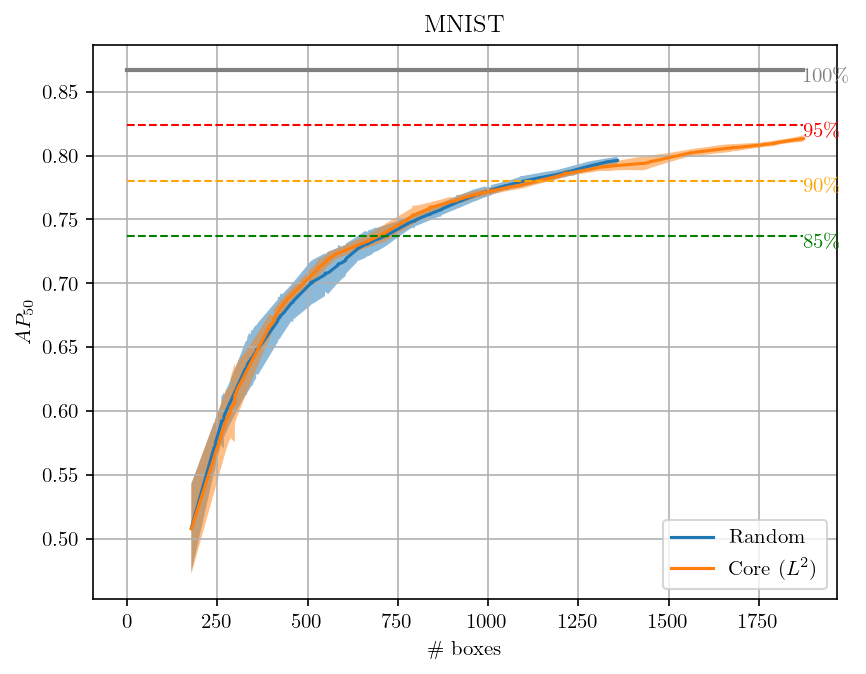

In [105]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "core"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3]],
                labels = ["Random", "Core ($L^2$)"],
                dataset="mnist_det_active", 
                x_scale="num_boxes",
                max_steps=15)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


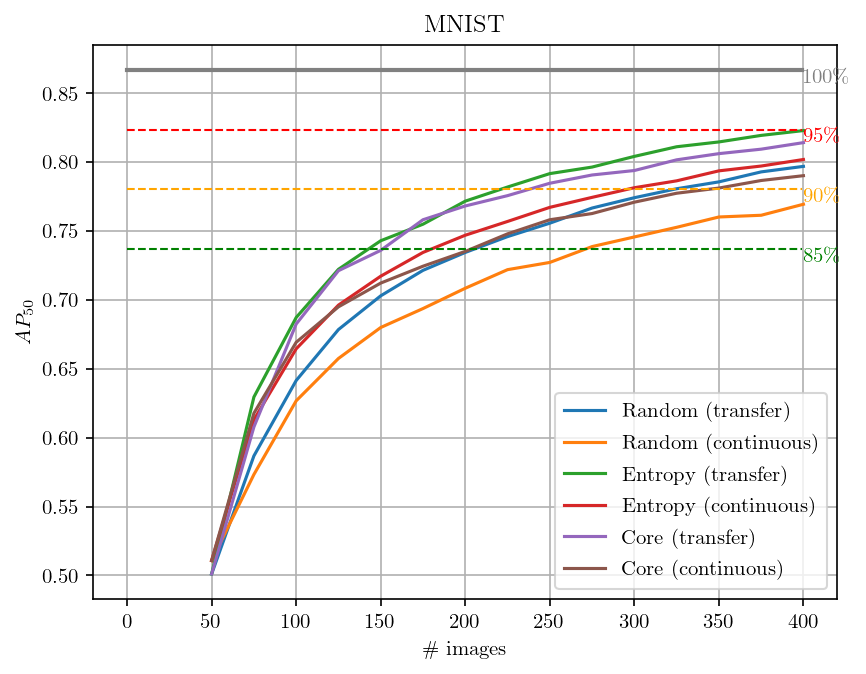

In [2]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "random", "entropy", "entropy", "core", "core"], 
                runs = [[0, 1, 2, 3], [6, 7, 8, 9], [0, 1, 2, 3], [6, 7, 8, 9], [0, 1, 2, 3], [6, 7, 8, 9]],
                labels = ["Random (transfer)", "Random (continuous)", "Entropy (transfer)", "Entropy (continuous)", "Core (transfer)", "Core (continuous)"],
                dataset="mnist_det_active", 
                x_scale="num_images",
                max_steps=15,
                bands=False)

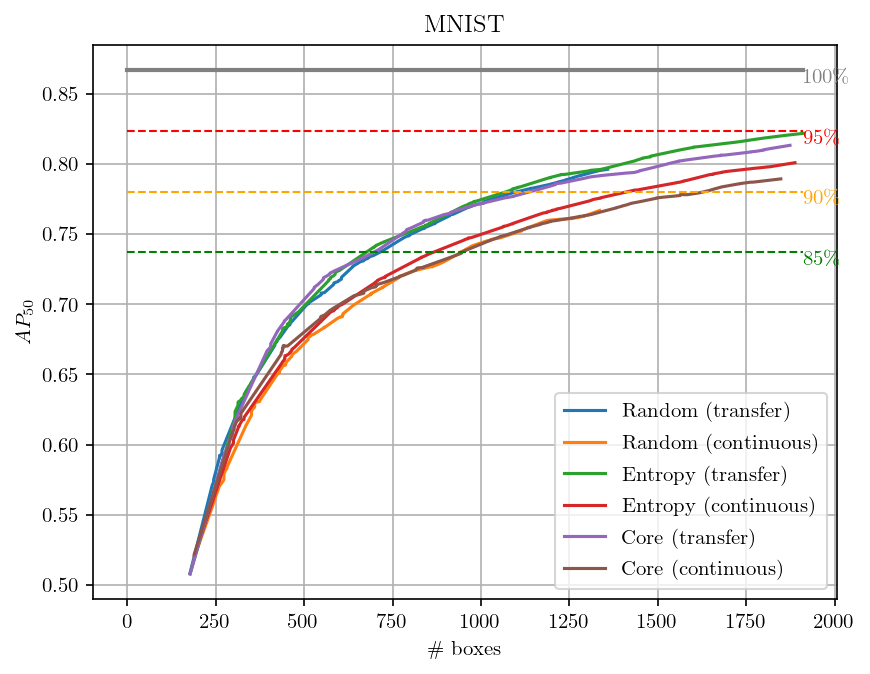

In [3]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "random", "entropy", "entropy", "core", "core"], 
                runs = [[0, 1, 2, 3], [6, 7, 8, 9], [0, 1, 2, 3], [6, 7, 8, 9], [0, 1, 2, 3], [6, 7, 8, 9]],
                labels = ["Random (transfer)", "Random (continuous)", "Entropy (transfer)", "Entropy (continuous)", "Core (transfer)", "Core (continuous)"],
                dataset="mnist_det_active", 
                x_scale="num_boxes",
                max_steps=15,
                bands=False)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


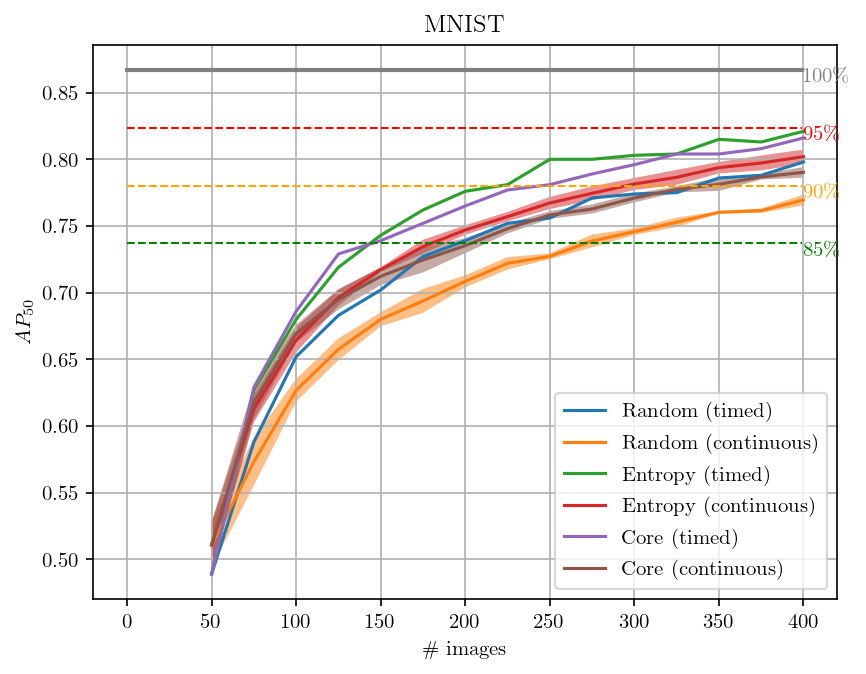

In [2]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random_timing", "random", "entropy_timing", "entropy", "core_timing", "core"], 
                runs = [[6], [6, 7, 8, 9], [6], [6, 7, 8, 9], [6], [6, 7, 8, 9]],
                labels = ["Random (timed)", "Random (continuous)", "Entropy (timed)", "Entropy (continuous)", "Core (timed)", "Core (continuous)"],
                dataset="mnist_det_active", 
                x_scale="num_images",
                max_steps=15,
                bands=True)

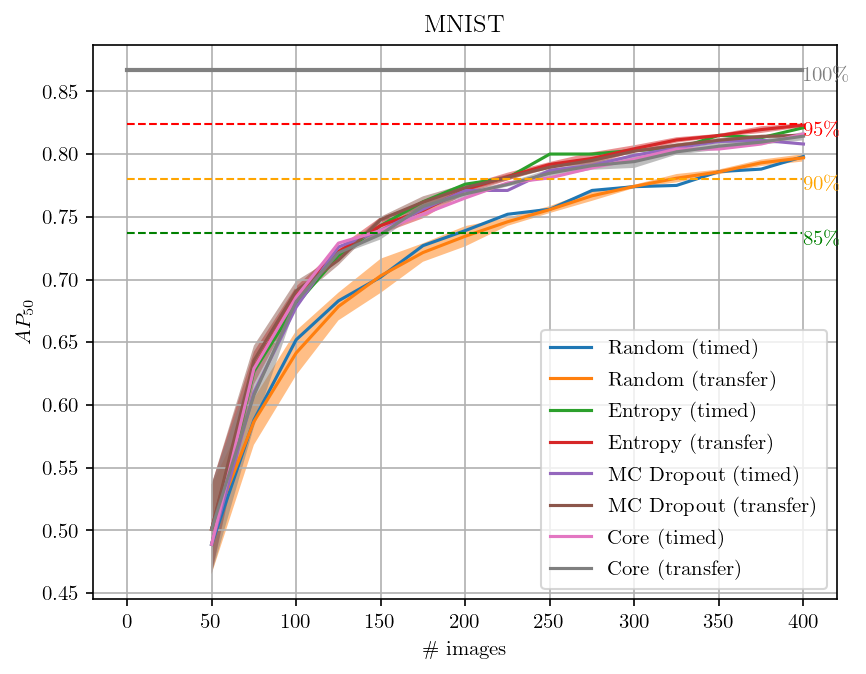

In [5]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random_timing", "random", "entropy_timing", "entropy", "dropout_timing", "dropout", "core_timing", "core"], 
                runs = [[6], [0, 1, 2, 3], [6], [0, 1, 2, 3], [6], [0, 1, 2, 3], [6], [0, 1, 2, 3]],
                labels = ["Random (timed)", "Random (transfer)", "Entropy (timed)", "Entropy (transfer)", "MC Dropout (timed)", "MC Dropout (transfer)", "Core (timed)", "Core (transfer)"],
                dataset="mnist_det_active", 
                x_scale="num_images",
                max_steps=15,
                bands=True)

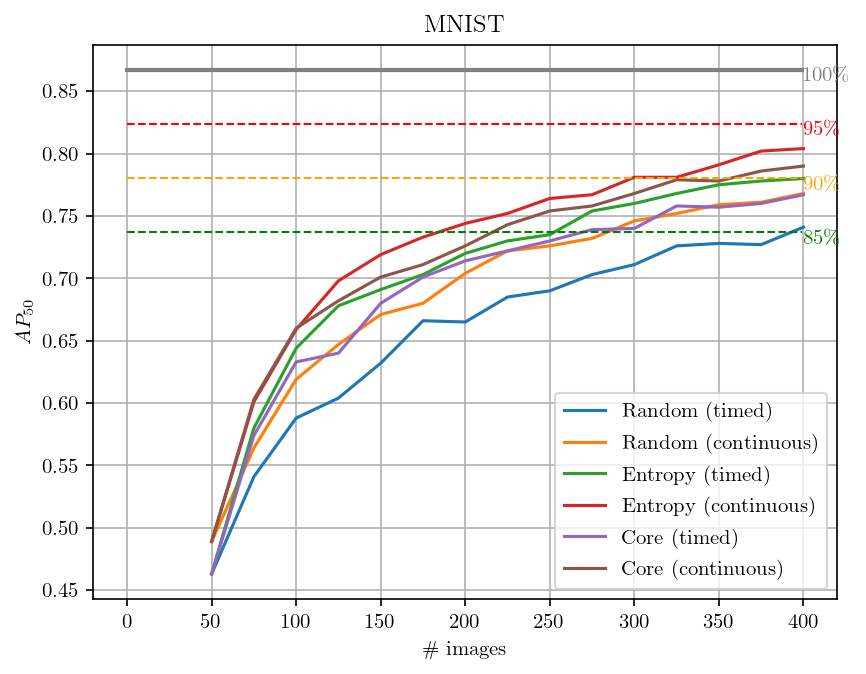

In [6]:
plt.title("MNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "random", "entropy", "entropy", "core", "core"], 
                runs = [[5], [6], [5], [6], [5], [6]],
                labels = ["Random (timed)", "Random (continuous)", "Entropy (timed)", "Entropy (continuous)", "Core (timed)", "Core (continuous)"],
                dataset="mnist_det_active", 
                x_scale="num_images",
                max_steps=15,
                bands=False)

# MNIST Comparison Baselines

(0.5, 0.87)

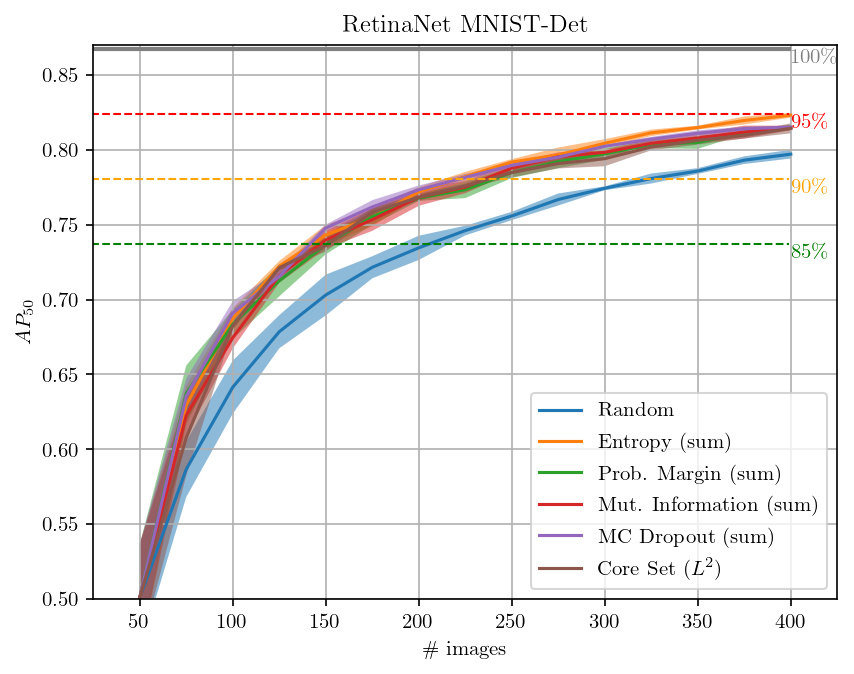

In [18]:
plt.title("RetinaNet MNIST-Det")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "entropy", "prob_margin", "mutual_information", "dropout", "core"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]],
                labels = ["Random", "Entropy (sum)", "Prob. Margin (sum)", "Mut. Information (sum)", "MC Dropout (sum)", "Core Set ($L^2$)"],
                dataset="mnist_det_active", 
                x_scale="num_images",
                max_steps=15,
                bands=True)
plt.xlim(25, 425)
plt.ylim(0.50, 0.87)

(0.5, 0.87)

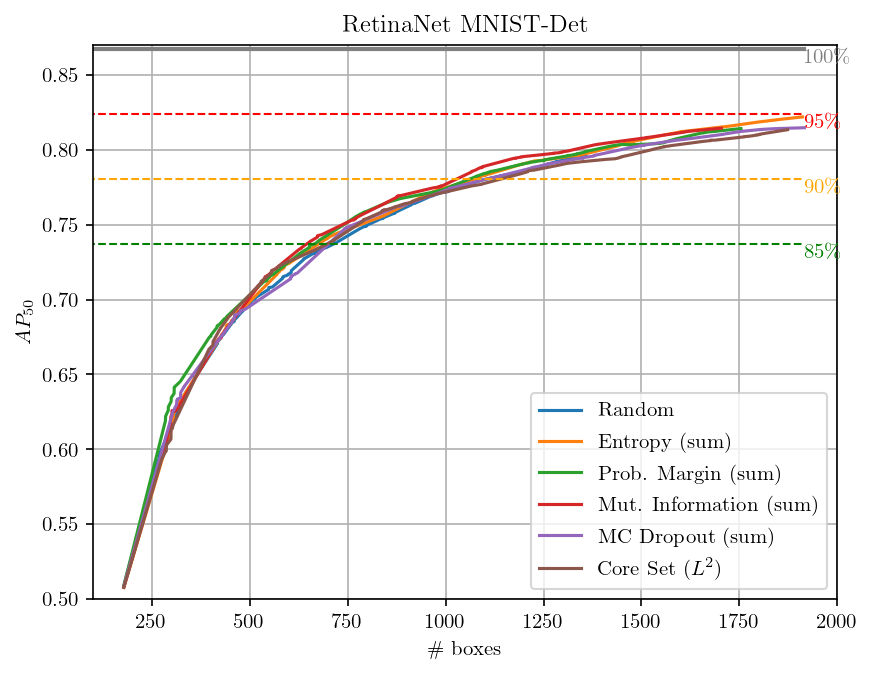

In [19]:
plt.title("RetinaNet MNIST-Det")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active",
                ["random", "entropy", "prob_margin", "mutual_information", "dropout", "core"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]],
                labels = ["Random", "Entropy (sum)", "Prob. Margin (sum)", "Mut. Information (sum)", "MC Dropout (sum)", "Core Set ($L^2$)"],
                dataset="mnist_det_active", 
                x_scale="num_boxes",
                max_steps=15,
                bands=False)
plt.xlim(100, 2000)
plt.ylim(0.50, 0.87)

# EMNIST Entropy Baselines

(75.0, 1600.0)

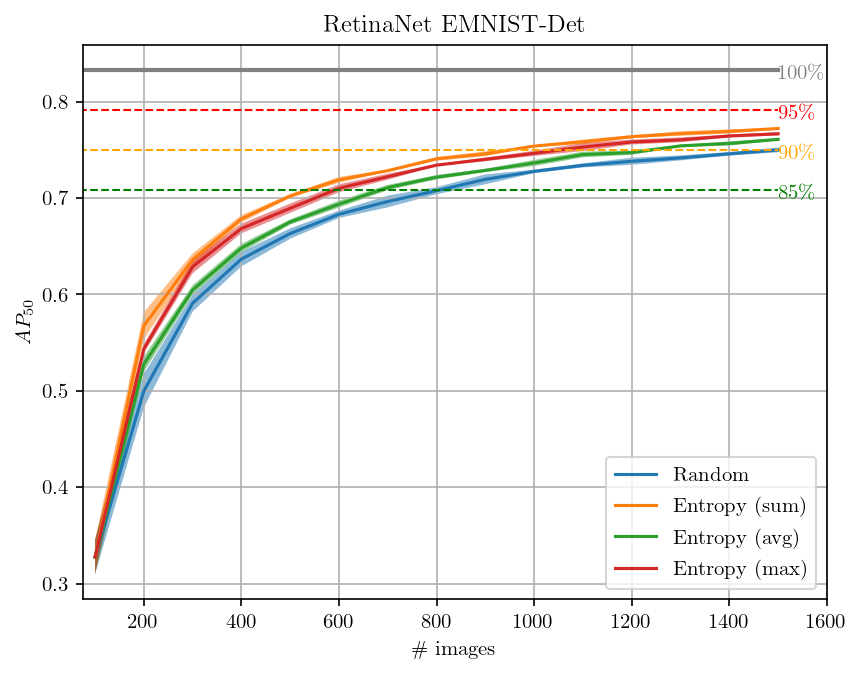

In [13]:
plt.title("RetinaNet EMNIST-Det")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/emnist_det_active",
                ["random", "entropy", "entropy", "entropy"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "Entropy (sum)", "Entropy (avg)", "Entropy (max)"],
                dataset="emnist_det_active", 
                x_scale="num_images",
                max_steps=15
)
plt.xlim(75, 1600)

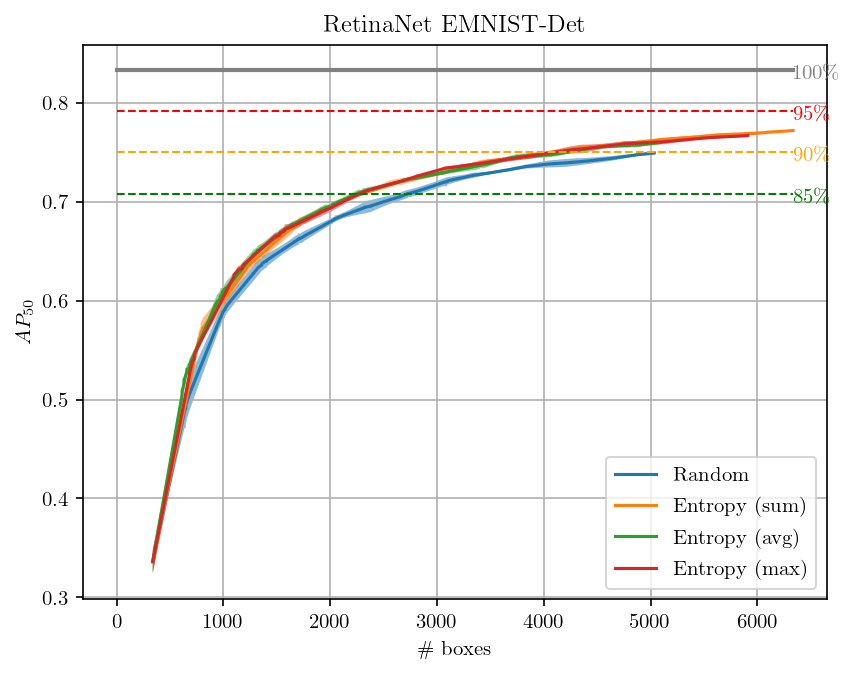

In [22]:
plt.title("RetinaNet EMNIST-Det")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/emnist_det_active",
                ["random", "entropy", "entropy", "entropy"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "Entropy (sum)", "Entropy (avg)", "Entropy (max)"],
                dataset="emnist_det_active", 
                x_scale="num_boxes",
                max_steps=15
)

# EMNIST Probability Margin Baselines

15
15
15
15


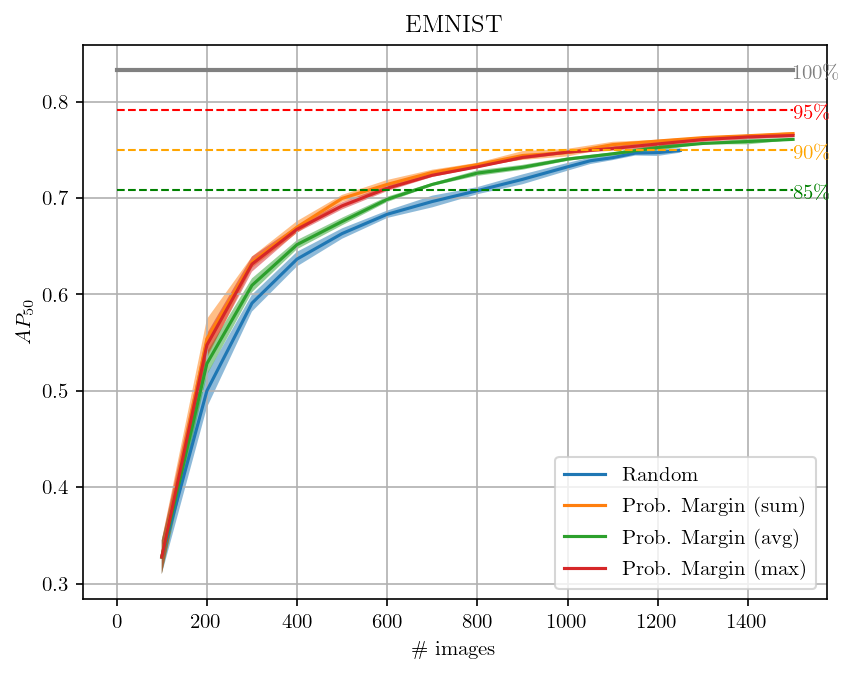

In [27]:
plt.title("EMNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/emnist_det_active",
                ["random", "prob_margin", "prob_margin", "prob_margin"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "Prob. Margin (sum)", "Prob. Margin (avg)", "Prob. Margin (max)"],
                dataset="emnist_det_active", 
                x_scale="num_images",
                max_steps=15)

15
15
15
15


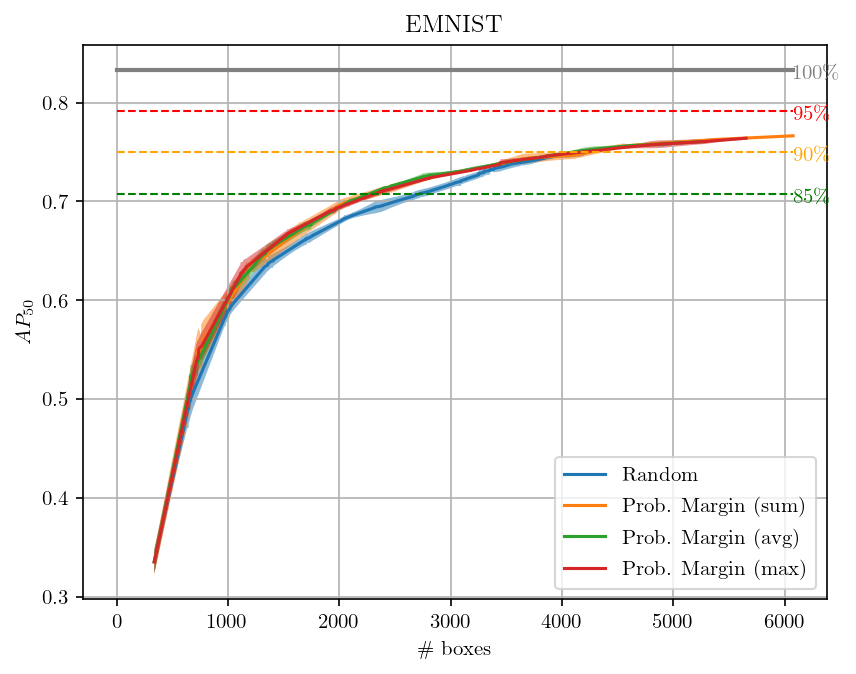

In [108]:
plt.title("EMNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/emnist_det_active",
                ["random", "prob_margin", "prob_margin", "prob_margin"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "Prob. Margin (sum)", "Prob. Margin (avg)", "Prob. Margin (max)"],
                dataset="emnist_det_active", 
                x_scale="num_boxes",
                max_steps=15)

# EMNIST Dropout Baselines

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


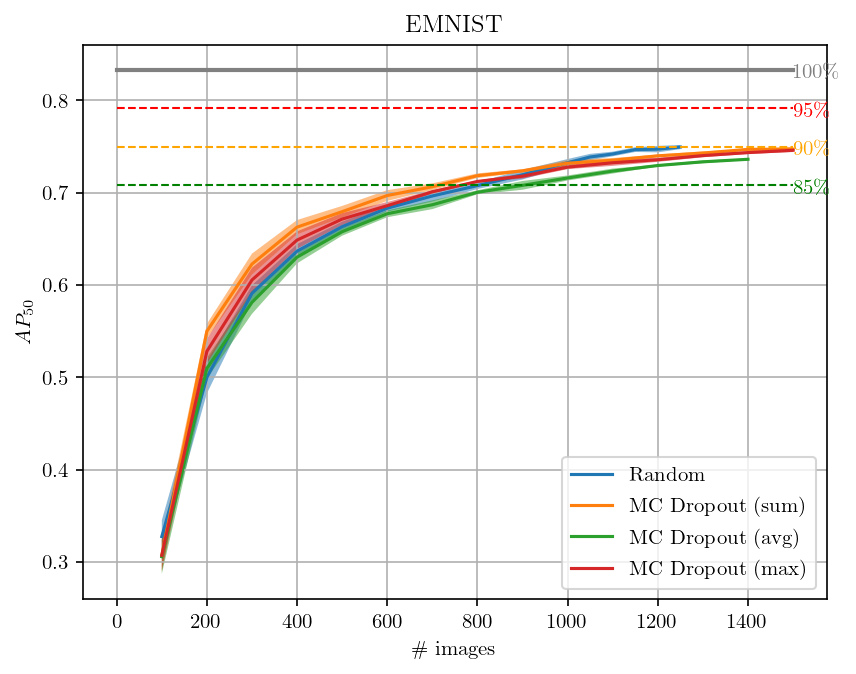

In [2]:
plt.title("EMNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/emnist_det_active",
                ["random", "dropout", "dropout", "dropout"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "MC Dropout (sum)", "MC Dropout (avg)", "MC Dropout (max)"],
                dataset="emnist_det_active", 
                x_scale="num_images",
                max_steps=15)

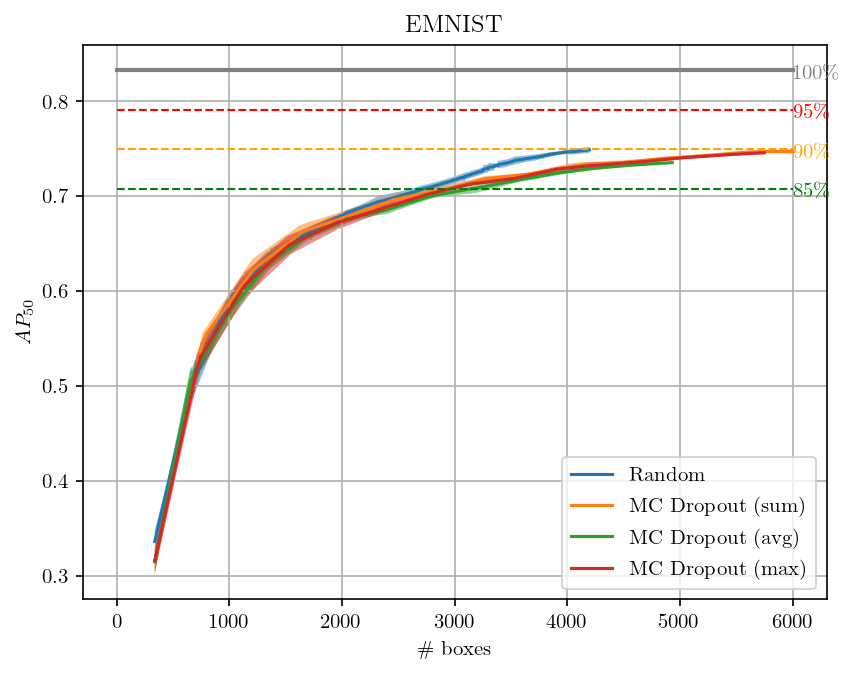

In [3]:
plt.title("EMNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/emnist_det_active",
                ["random", "dropout", "dropout", "dropout"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "MC Dropout (sum)", "MC Dropout (avg)", "MC Dropout (max)"],
                dataset="emnist_det_active", 
                x_scale="num_boxes",
                max_steps=15)

# EMNIST Mutual Information Baselines

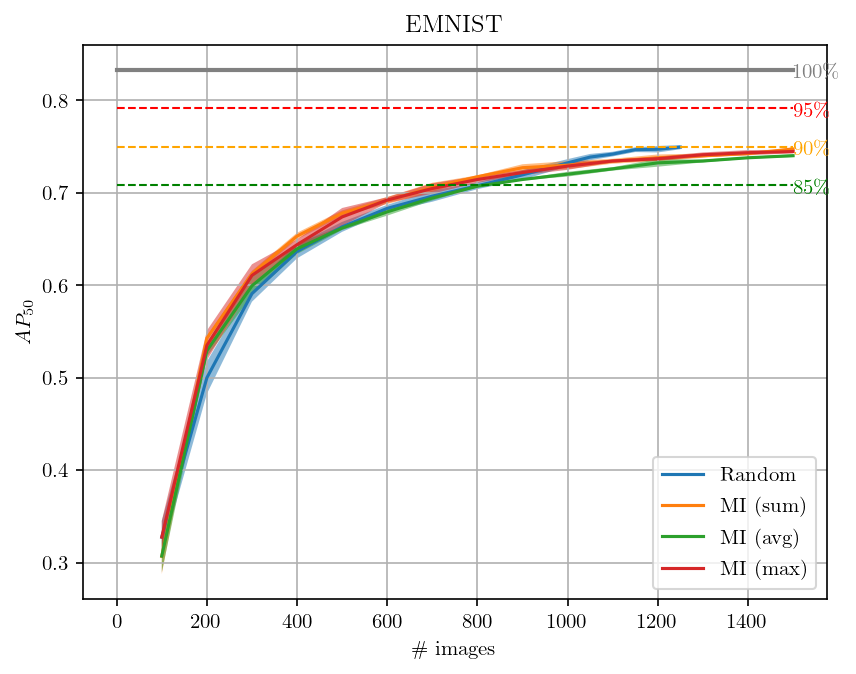

In [4]:
plt.title("EMNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/emnist_det_active",
                ["random", "mutual_information", "mutual_information", "mutual_information"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "MI (sum)", "MI (avg)", "MI (max)"],
                dataset="emnist_det_active", 
                x_scale="num_images",
                max_steps=15)

15
15
15
15


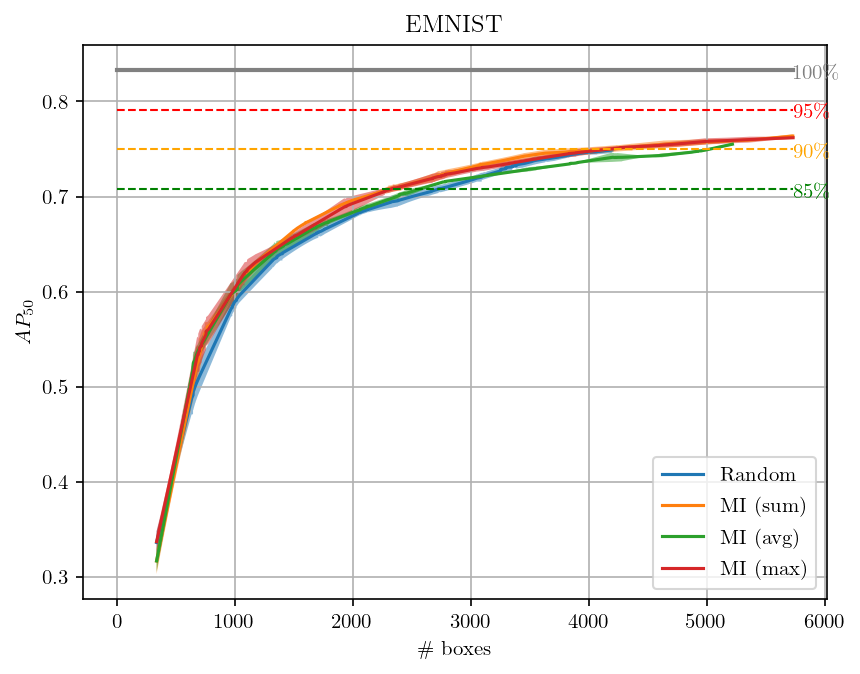

In [111]:
plt.title("EMNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/emnist_det_active",
                ["random", "mutual_information", "mutual_information", "mutual_information"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13],  [20, 21, 22, 23]],
                labels = ["Random", "MI (sum)", "MI (avg)", "MI (max)"],
                dataset="emnist_det_active", 
                x_scale="num_boxes",
                max_steps=15)

# EMNIST Core Set Baselines

15
15


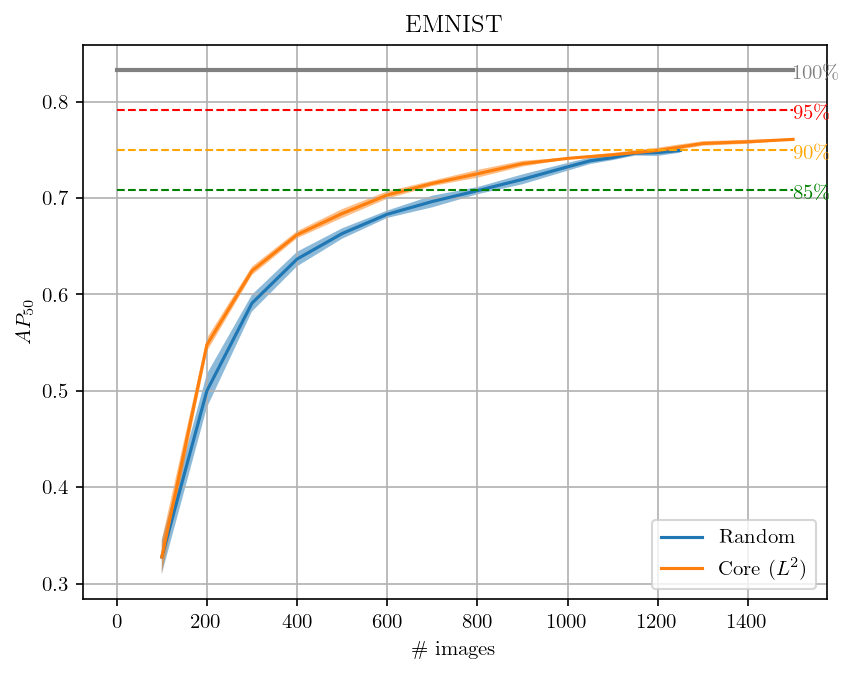

In [31]:
plt.title("EMNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/emnist_det_active",
                ["random", "core"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3]],
                labels = ["Random", "Core ($L^2$)"],
                dataset="emnist_det_active", 
                x_scale="num_images",
                max_steps=15)

15
15


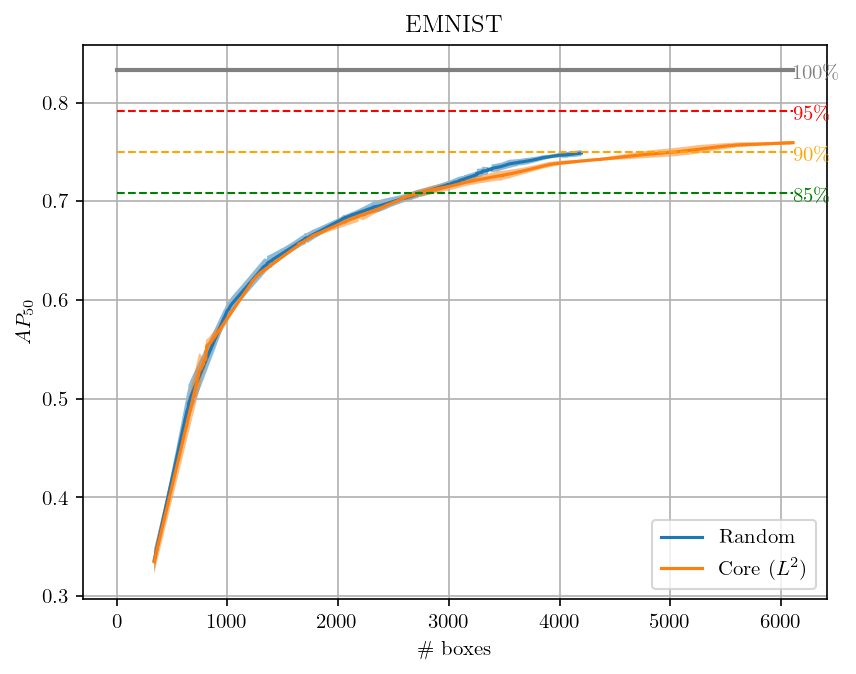

In [112]:
plt.title("EMNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/emnist_det_active",
                ["random", "core"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3]],
                labels = ["Random", "Core ($L^2$)"],
                dataset="emnist_det_active", 
                x_scale="num_boxes",
                max_steps=15)

(0.35, 0.85)

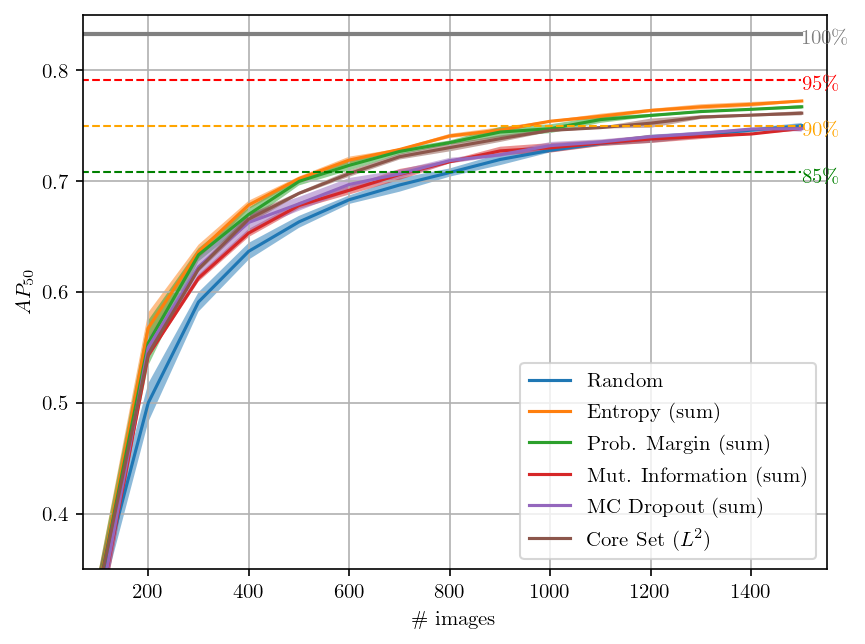

In [8]:
# plt.title("EMNIST")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/emnist_det_active",
                ["random", "entropy", "prob_margin", "mutual_information", "dropout", "core"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]],
                labels = ["Random", "Entropy (sum)", "Prob. Margin (sum)", "Mut. Information (sum)", "MC Dropout (sum)", "Core Set ($L^2$)"],
                dataset="emnist_det_active", 
                x_scale="num_images",
                max_steps=15,
                bands=True)
plt.xlim(70, 1550)
plt.ylim(0.35, 0.85)

(0.32, 0.86)

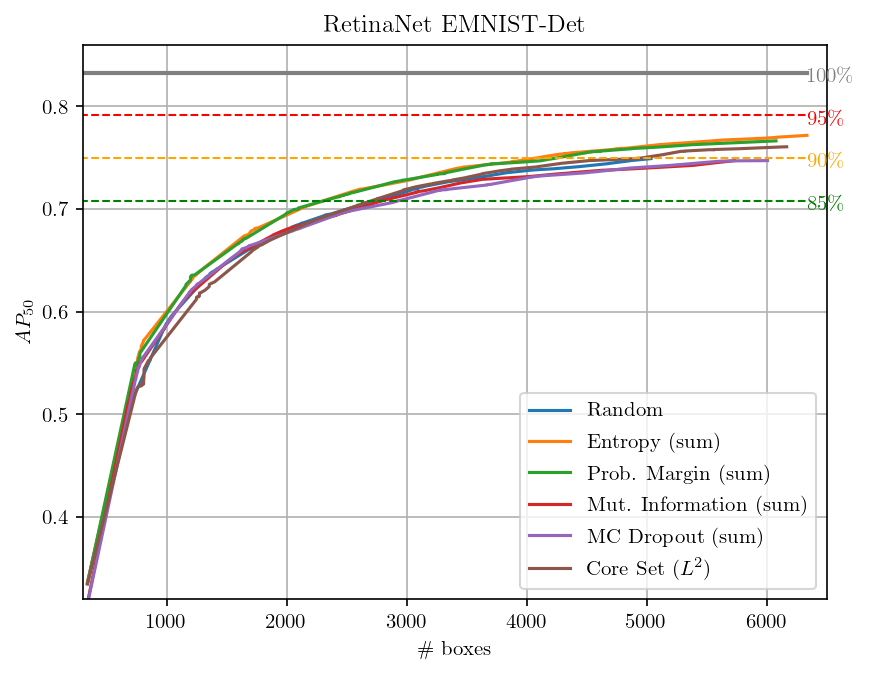

In [20]:
plt.title("RetinaNet EMNIST-Det")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/emnist_det_active",
                ["random", "entropy", "prob_margin", "mutual_information", "dropout", "core"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]],
                labels = ["Random", "Entropy (sum)", "Prob. Margin (sum)", "Mut. Information (sum)", "MC Dropout (sum)", "Core Set ($L^2$)"],
                dataset="emnist_det_active", 
                x_scale="num_boxes", 
                max_steps=15,
                bands=False)
plt.xlim(300, 6500)
plt.ylim(0.32, 0.86)

# EMNIST Continous Comparison

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


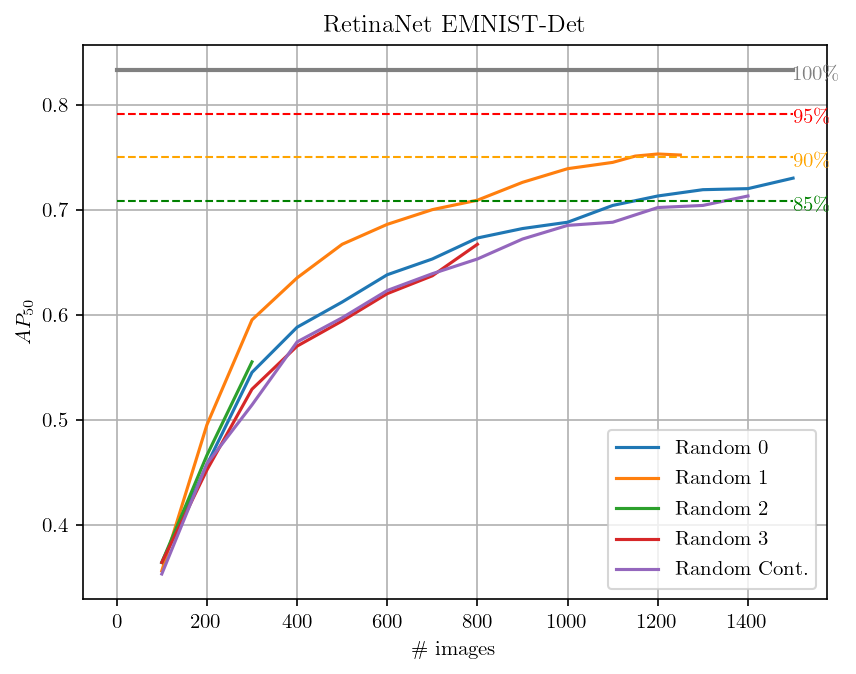

In [3]:
plt.title("RetinaNet EMNIST-Det")
plot_comparison("/home/schubert/MMDetection-AL/mm-detection-active-learning-for-object-detection/checkpoints/retinanet/emnist_det_active/",
                ["random", "random", "random", "random", "random"], 
                runs = [[0], [1], [2], [3], [6]],
                labels = ["Random 0", "Random 1", "Random 2", "Random 3", "Random Cont.",],
                dataset="emnist_det_active", 
                x_scale="num_images", 
                max_steps=15,
                bands=False)

# YOLO Baselines

16
15
16


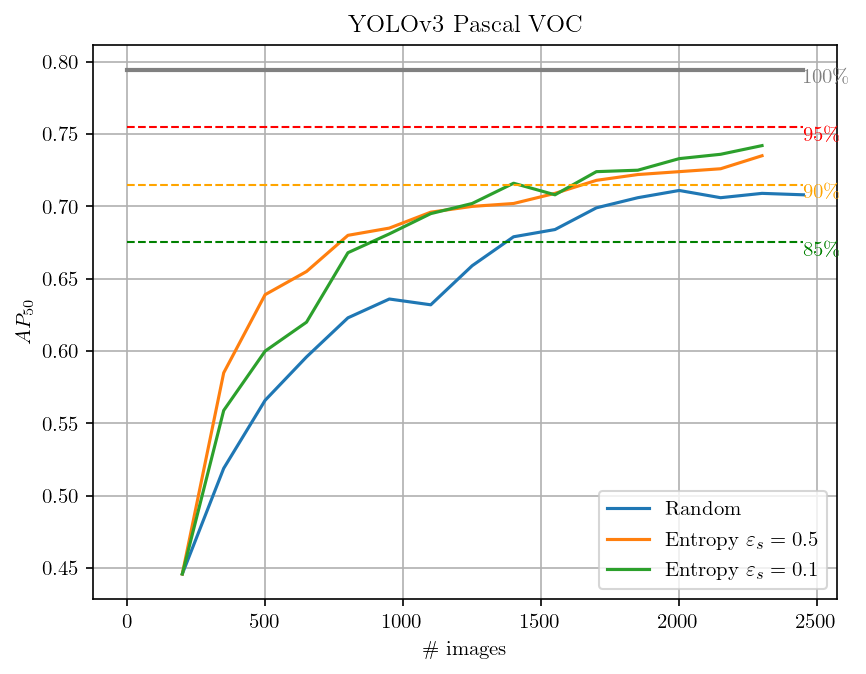

In [37]:
plt.title("YOLOv3 Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/mm-detection-active-learning-for-object-detection/results/al_runs/yolov3/voc",
                ["random", "entropy", "entropy_01"],
                dataset="voc",
                arch="yolov3",
                runs=[[0], [0], [0]], 
                labels=["Random", "Entropy $\\varepsilon_s = 0.5$", "Entropy $\\varepsilon_s = 0.1$"],
                x_scale="num_images")

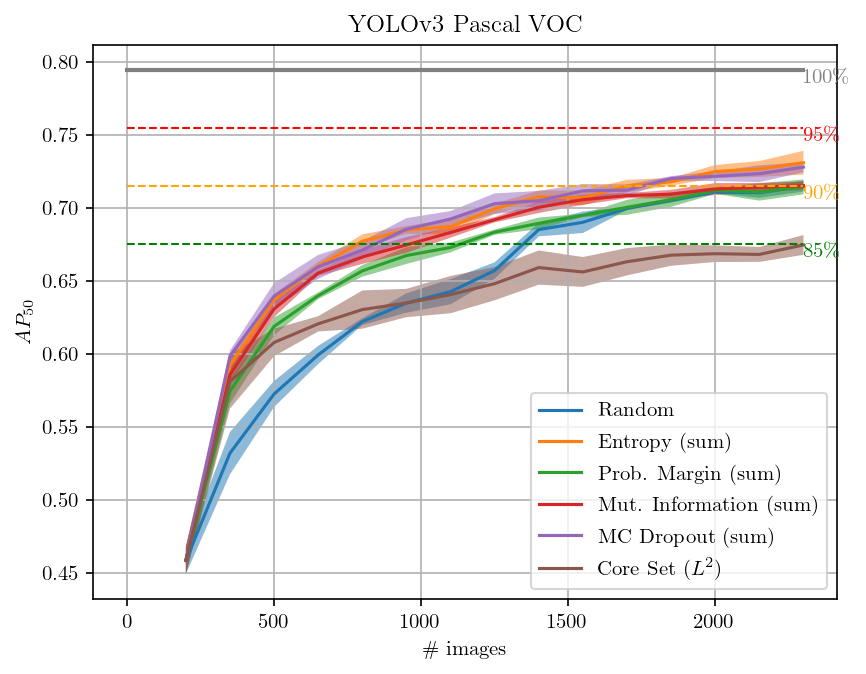

In [5]:
plt.title("YOLOv3 Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/yolov3/voc",
                ["random", "entropy", "prob_margin", "mutual_information", "dropout", "core"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]],
                labels = ["Random", "Entropy (sum)", "Prob. Margin (sum)", "Mut. Information (sum)", "MC Dropout (sum)", "Core Set ($L^2$)"],
                arch="yolov3",
                dataset="voc", 
                x_scale="num_images",
                max_steps=15, bands=True)

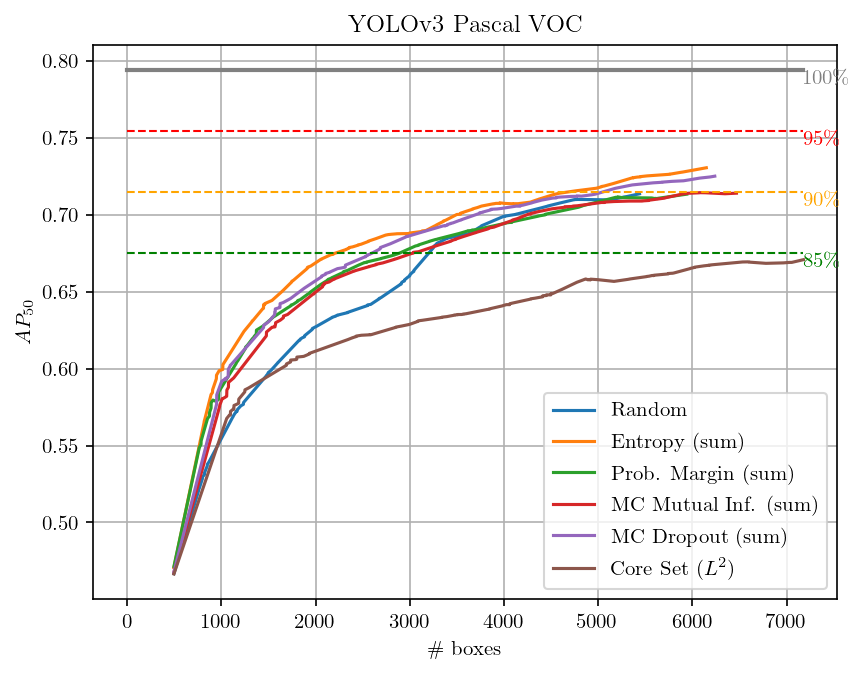

In [6]:
plt.title("YOLOv3 Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/yolov3/voc",
                ["random", "entropy", "prob_margin", "mutual_information", "dropout", "core"],
                dataset="voc",
                arch="yolov3",
                runs=[[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]], 
                labels=["Random", "Entropy (sum)", "Prob. Margin (sum)", "MC Mutual Inf. (sum)", "MC Dropout (sum)", "Core Set ($L^2$)"],
                x_scale="num_boxes", 
                max_steps=15,
                bands=False)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


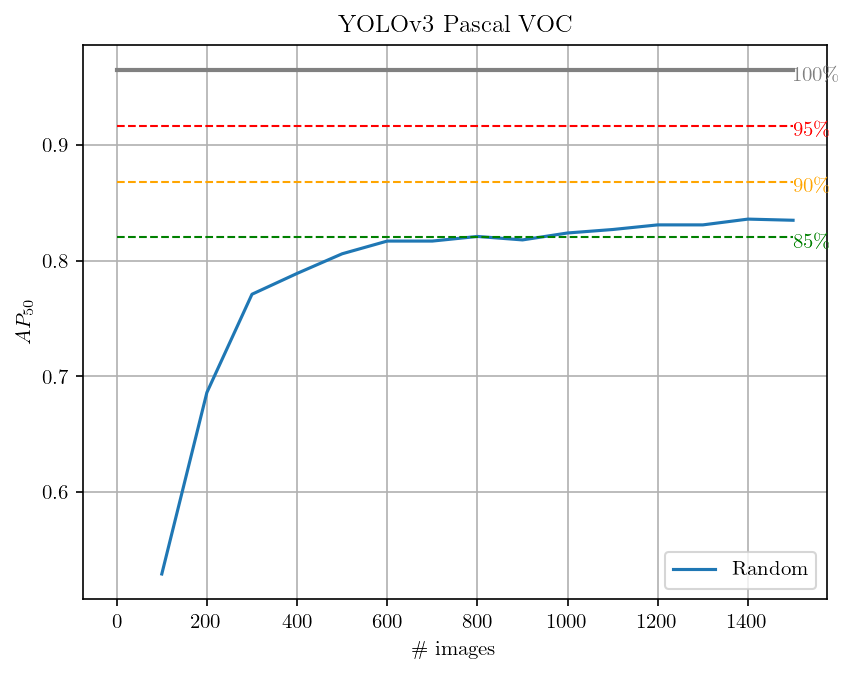

In [2]:
plt.title("YOLOv3 Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/yolov3/emnist_det_active",
                ["random"],
                dataset="emnist_det_active",
                arch="yolov3",
                runs=[[0]], 
                labels=["Random"],
                x_scale="num_images", 
                max_steps=15)

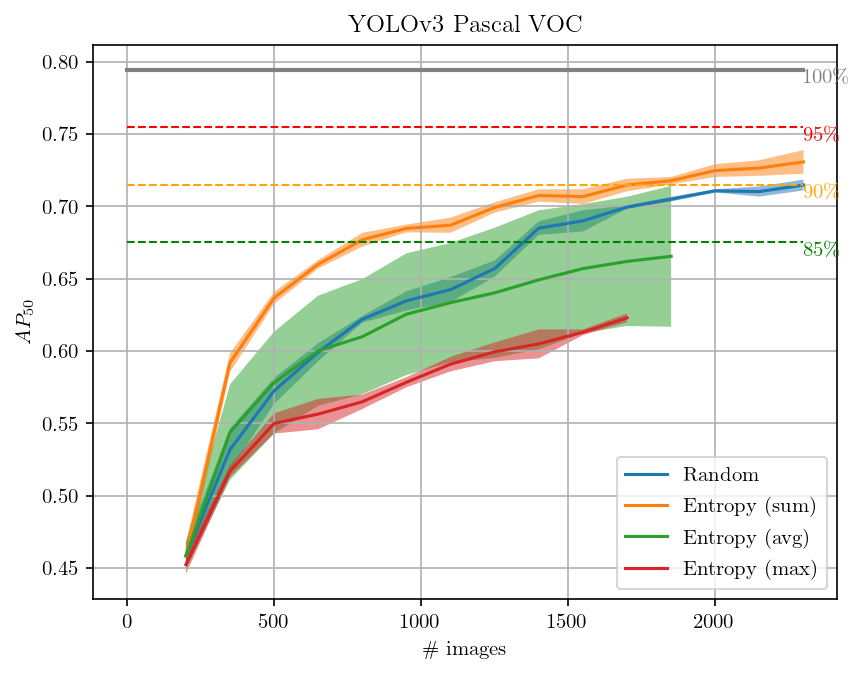

In [10]:
plt.title("YOLOv3 Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/yolov3/voc",
                ["random", "entropy", "entropy", "entropy"],
                dataset="voc",
                arch="yolov3",
                runs=[[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13], [20, 21]], 
                labels=["Random", "Entropy (sum)", "Entropy (avg)", "Entropy (max)"],
                x_scale="num_images", 
                max_steps=15,
                bands=True)

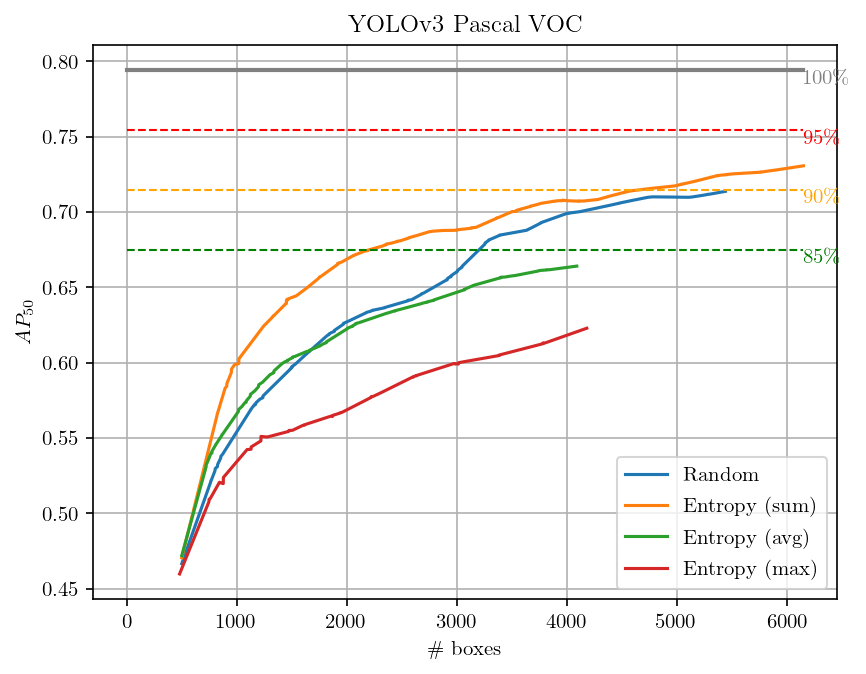

In [12]:
plt.title("YOLOv3 Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/yolov3/voc",
                ["random", "entropy", "entropy", "entropy"],
                dataset="voc",
                arch="yolov3",
                runs=[[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13], [20, 21]], 
                labels=["Random", "Entropy (sum)", "Entropy (avg)", "Entropy (max)"],
                x_scale="num_boxes", 
                max_steps=15,
                bands=False)

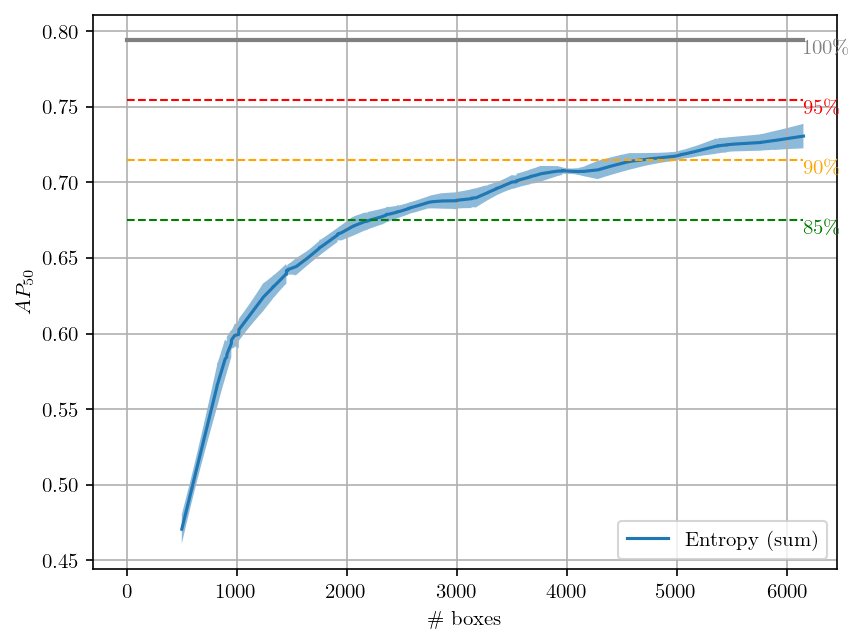

In [17]:
# plt.title("YOLOv3 Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/yolov3/voc",
                ["entropy"], 
                runs = [[0, 1, 2, 3]],
                labels = ["Entropy (sum)"],
                arch="yolov3",
                dataset="voc", 
                x_scale="num_boxes",
                max_steps=15, bands=True)

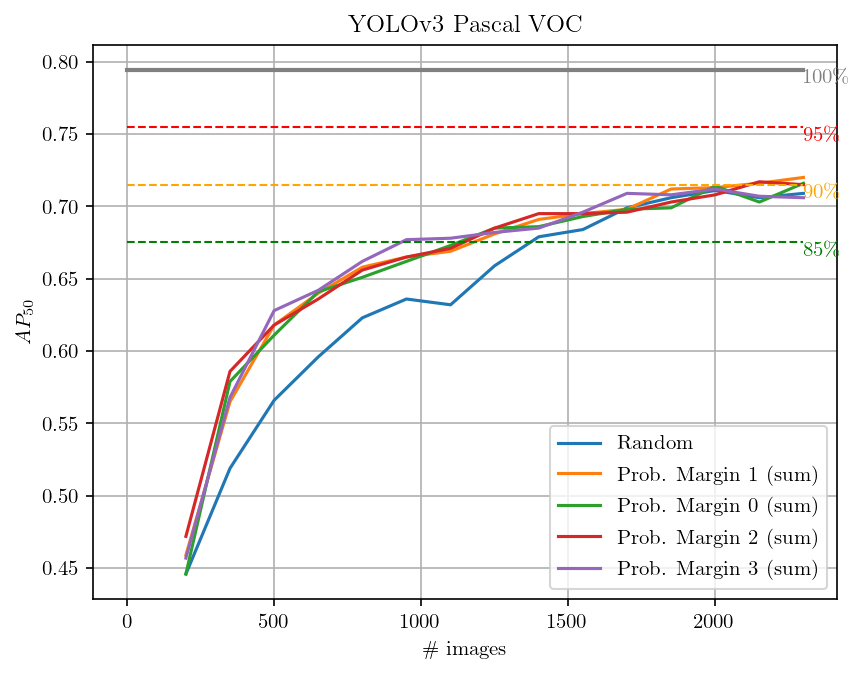

In [3]:
plt.title("YOLOv3 Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/yolov3/voc",
                ["random", "prob_margin", "prob_margin", "prob_margin", "prob_margin"], 
                runs = [[0], [1], [0], [2], [3]],
                labels = ["Random", "Prob. Margin 1 (sum)", "Prob. Margin 0 (sum)", "Prob. Margin 2 (sum)", "Prob. Margin 3 (sum)"],
                arch="yolov3",
                dataset="voc", 
                x_scale="num_images",
                max_steps=15, bands=False)

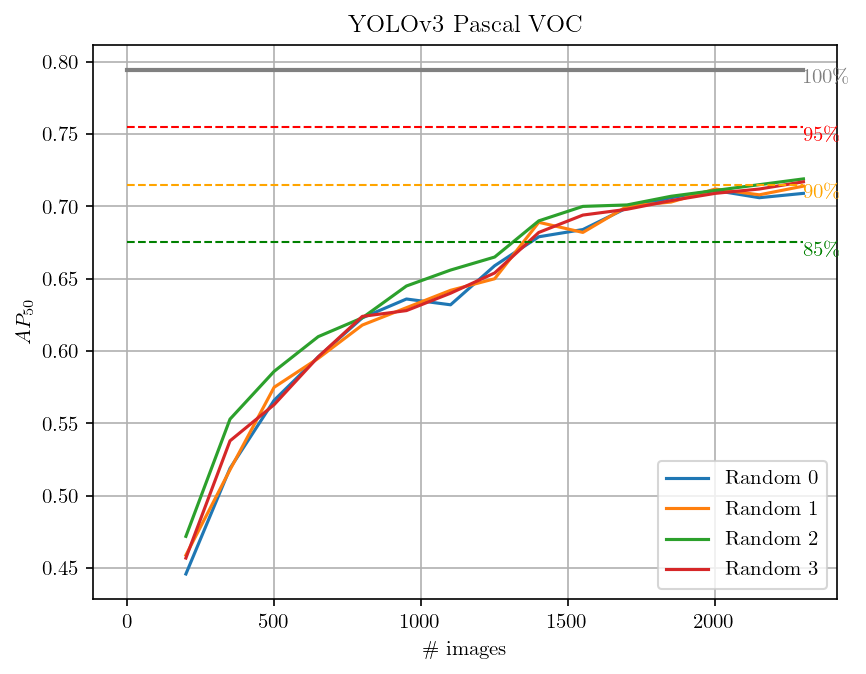

In [4]:
plt.title("YOLOv3 Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/yolov3/voc",
                ["random", "random", "random", "random"], 
                runs = [[0], [1], [2], [3]],
                labels = ["Random 0", "Random 1", "Random 2", "Random 3"],
                arch="yolov3",
                dataset="voc", 
                x_scale="num_images",
                max_steps=15, bands=False)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


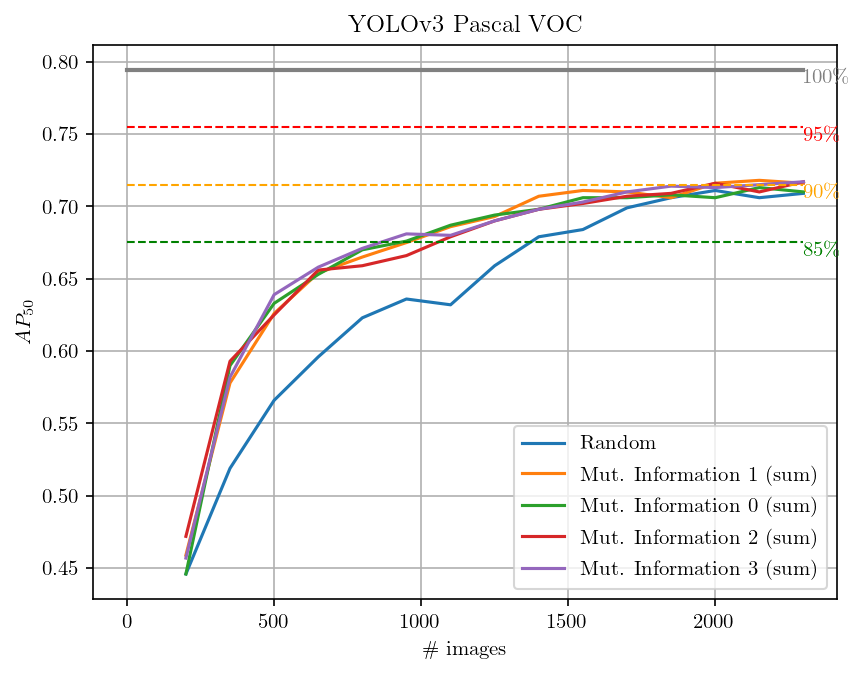

In [2]:
plt.title("YOLOv3 Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/yolov3/voc",
                ["random", "mutual_information", "mutual_information", "mutual_information", "mutual_information"], 
                runs = [[0], [1], [0], [2], [3]],
                labels = ["Random", "Mut. Information 1 (sum)", "Mut. Information 0 (sum)", "Mut. Information 2 (sum)", "Mut. Information 3 (sum)"],
                arch="yolov3",
                dataset="voc", 
                x_scale="num_images",
                max_steps=15, bands=False)

# Faster RCNN Baselines

15
15
15
14


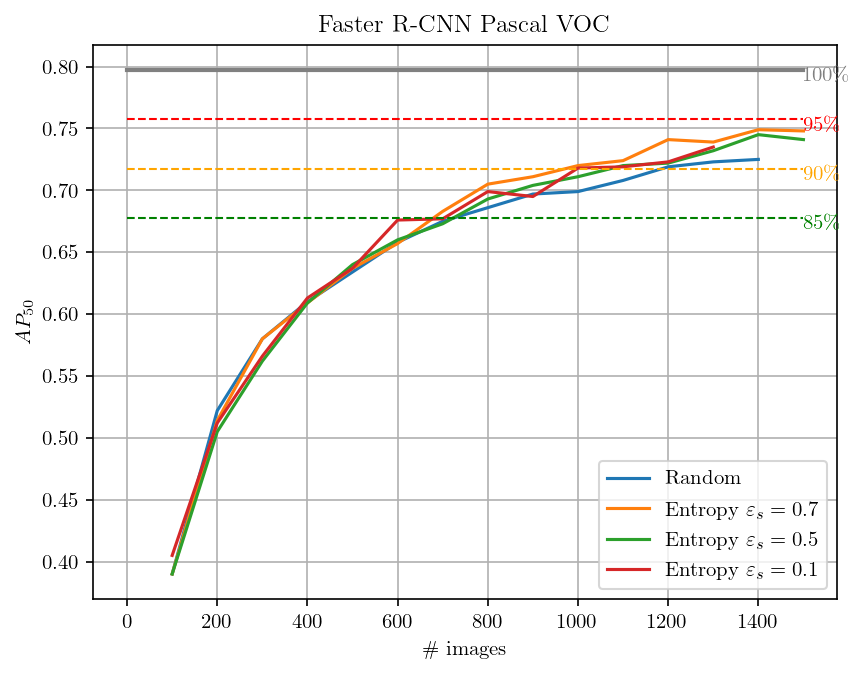

In [53]:
plt.title("Faster R-CNN Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/mm-detection-active-learning-for-object-detection/results/al_runs/frcnn/voc",
                ["random", "entropy", "entropy_05", "entropy_01"],
                dataset="voc",
                arch="faster_rcnn",
                runs=[[0], [0], [0], [0]], 
                labels=["Random", "Entropy $\\varepsilon_s = 0.7$", "Entropy $\\varepsilon_s = 0.5$", "Entropy $\\varepsilon_s = 0.1$"],
                x_scale="num_images")

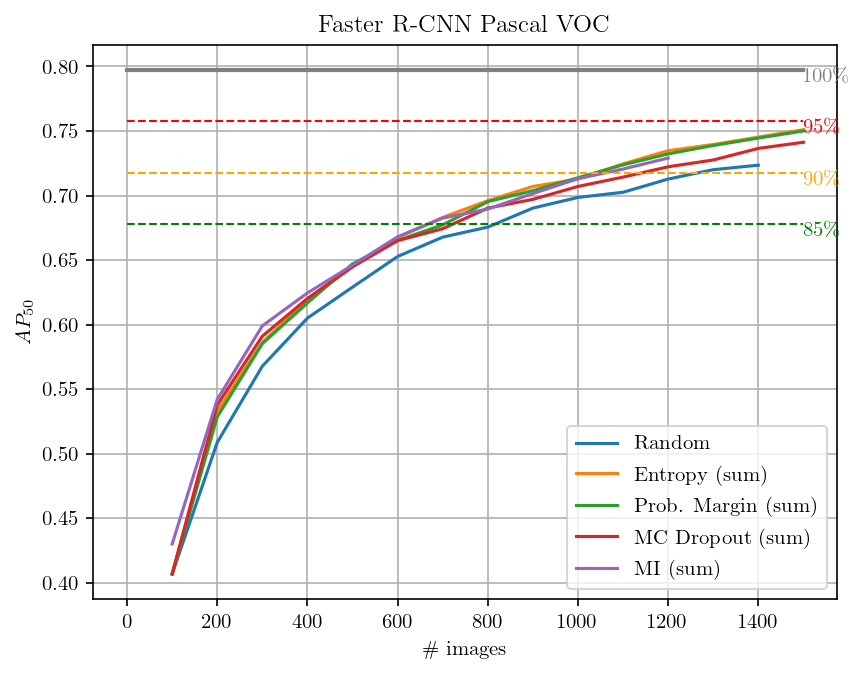

In [7]:
plt.title("Faster R-CNN Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/frcnn/voc",
                ["random", "entropy", "prob_margin", "dropout", "mutual_information"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [1, 2]],
                labels = ["Random", "Entropy (sum)", "Prob. Margin (sum)", "MC Dropout (sum)", "MI (sum)"],
                arch="faster_rcnn",
                dataset="voc", 
                x_scale="num_images",
                max_steps=15,
                bands=False)

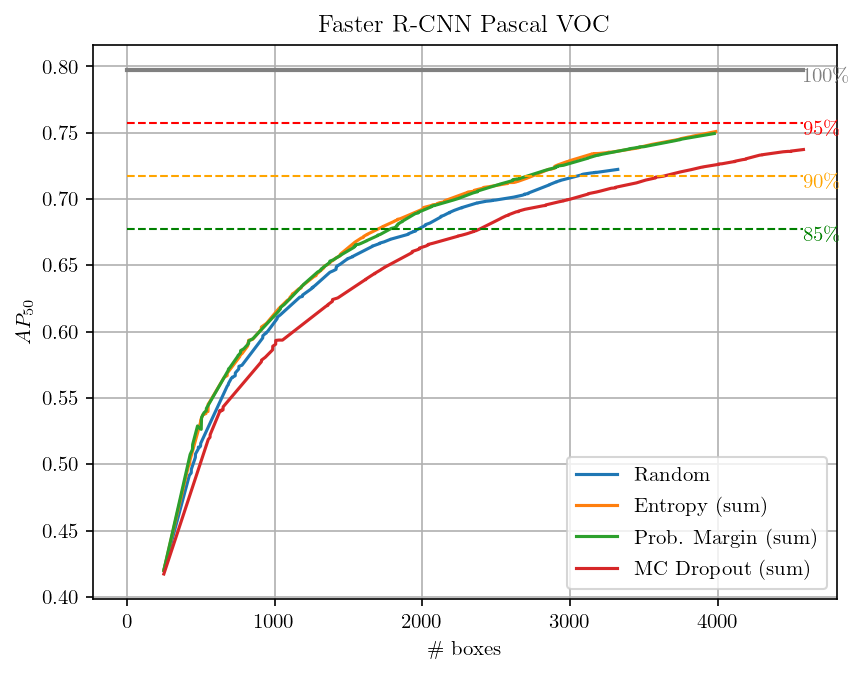

In [21]:
plt.title("Faster R-CNN Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/frcnn/voc",
                ["random", "entropy", "prob_margin", "dropout"],#, "mutual_information"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]],#, [1, 2]],
                labels = ["Random", "Entropy (sum)", "Prob. Margin (sum)", "MC Dropout (sum)"],#, "MI (sum)"],
                arch="faster_rcnn",
                dataset="voc", 
                x_scale="num_boxes",
                max_steps=15,
                bands=False)

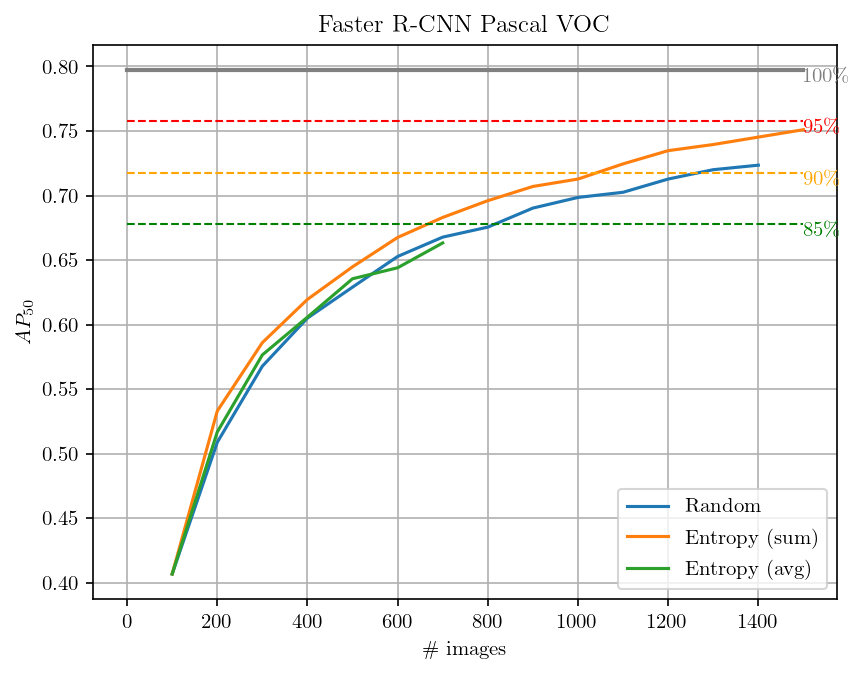

In [9]:
plt.title("Faster R-CNN Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/frcnn/voc",
                ["random", "entropy", "entropy"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13]],
                labels = ["Random", "Entropy (sum)", "Entropy (avg)"],
                arch="faster_rcnn",
                dataset="voc", 
                x_scale="num_images",
                max_steps=15,
                bands=False)

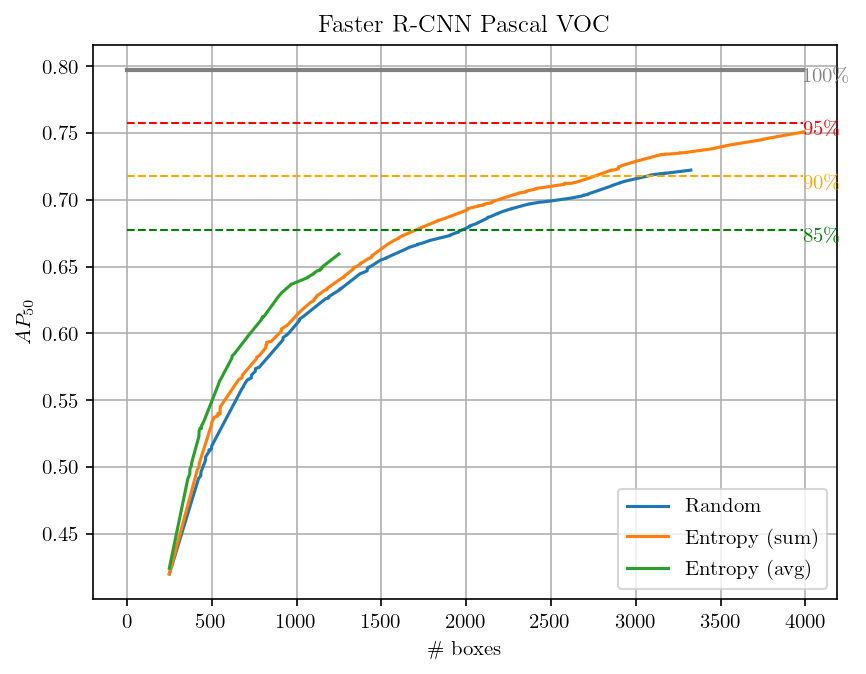

In [10]:
plt.title("Faster R-CNN Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results_aggr/al_runs/frcnn/voc",
                ["random", "entropy", "entropy"], 
                runs = [[0, 1, 2, 3], [0, 1, 2, 3], [10, 11, 12, 13]],
                labels = ["Random", "Entropy (sum)", "Entropy (avg)"],
                arch="faster_rcnn",
                dataset="voc", 
                x_scale="num_boxes",
                max_steps=15,
                bands=False)

# Jülich Proceedings Plots

21
17
11


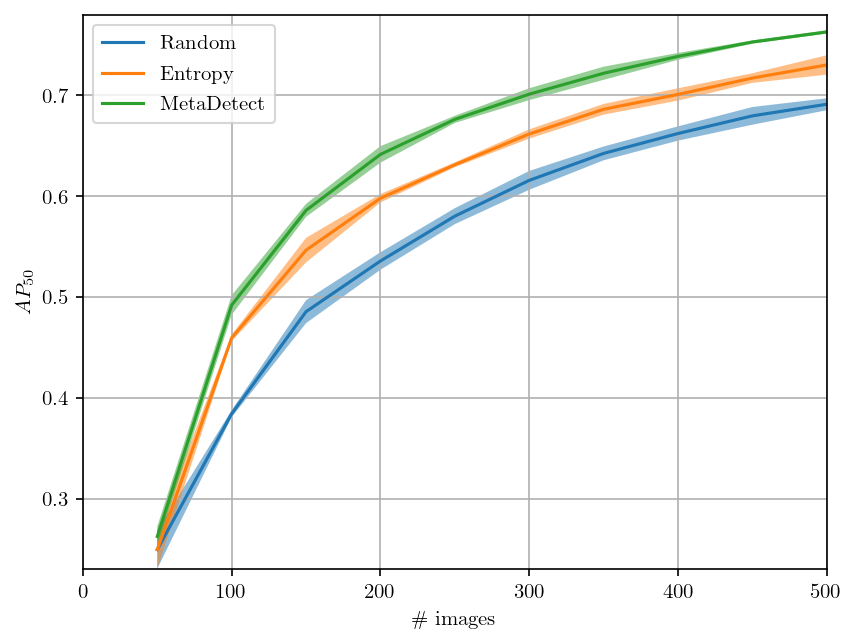

In [23]:
# plt.title("Faster R-CNN Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/results/al_runs/retinanet_bs=4_md_tests/mnist_det_active",
                ["random", "entropy", "meta_detect"],
                dataset="mnist_det",
                arch="retinanet",
                runs=[[0, 1, 2, 3], [0, 1, 2,3 ], [0, 1, 2, 3]], 
                labels=["Random", "Entropy", "MetaDetect"],
                x_scale="num_images",
                plot_ylimits=(0.23, 0.78))
plt.xlim(0, 500)
plt.savefig("/home/riedlinger/Desktop/images/meta_detect_vs_baselines.pdf", bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()

16
16
16
16
16
15


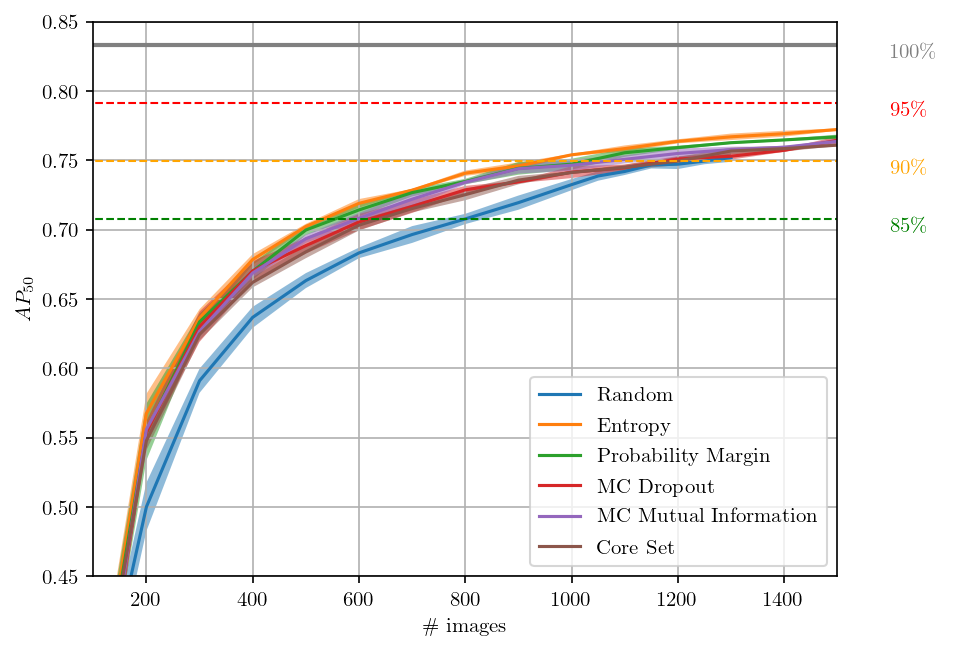

In [31]:
plot_comparison("/home/riedlinger/al_nutshell/results/al_runs/retinanet/emnist_det_active",
                ["random", "entropy", "prob_margin", "dropout", "mutual_information", "core"],
                dataset="emnist_det_active",
                arch="retinanet",
                runs=[[0, 1, 2, 3], [0, 1, 2,3 ], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]], 
                labels=["Random", "Entropy", "Probability Margin", "MC Dropout", "MC Mutual Information", "Core Set"],
                x_scale="num_images")
plt.xlim(100, 1500)
plt.ylim(0.45, 0.85)
plt.savefig("/home/riedlinger/Desktop/images/baselines.pdf", bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


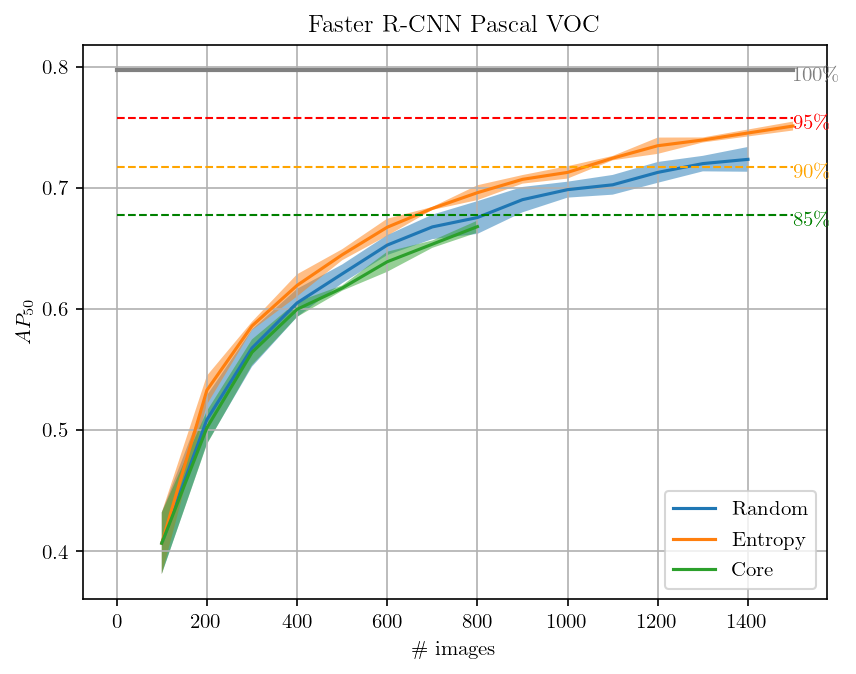

In [3]:
plt.title("Faster R-CNN Pascal VOC")
plot_comparison("/home/riedlinger/al_nutshell/mm-detection-active-learning-for-object-detection/results/al_runs/frcnn/voc",
                ["random", "entropy", "core"],
                dataset="voc",
                arch="faster_rcnn",
                runs=[[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]], 
                labels=["Random", "Entropy", "Core"],
                x_scale="num_images")

# Timing

In [6]:
import os.path as osp
import numpy as np
import json
p = "/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active"
for m in ["random", "entropy", "core"]:
    timings = []
    for i_run in range(6, 10):
        timings.append([])
        r = range(16) if m == "random" else range(1, 16)
        for i_step in r:
            d = json.load(open(osp.join(p, m, f"run_{i_run}", f"step_{i_step}", "timing.json"), "r"))
            timings[-1].append(list(d.values()))
    print(m)
    print(np.mean(np.array(timings), axis=0))

random_timing
[[6.32203920e+02 0.00000000e+00 6.32772446e-02 7.71868436e+02]
 [6.32476670e+02 0.00000000e+00 6.08561039e-02 6.90302416e+02]
 [6.42324153e+02 0.00000000e+00 5.92663288e-02 7.02508309e+02]
 [6.32540656e+02 0.00000000e+00 5.90398312e-02 6.93250151e+02]
 [6.42394500e+02 0.00000000e+00 5.59864044e-02 6.98935355e+02]
 [6.48992167e+02 0.00000000e+00 5.42249680e-02 7.08385949e+02]
 [6.34144696e+02 0.00000000e+00 5.37838936e-02 6.95197042e+02]
 [6.42720143e+02 0.00000000e+00 5.18510342e-02 7.01005032e+02]
 [6.44519492e+02 0.00000000e+00 5.18231392e-02 7.05413131e+02]
 [6.40673356e+02 0.00000000e+00 4.93431091e-02 6.99036514e+02]
 [6.46819573e+02 0.00000000e+00 4.77113724e-02 7.03725828e+02]
 [6.46306255e+02 0.00000000e+00 4.70495224e-02 7.10595343e+02]
 [6.45397607e+02 0.00000000e+00 4.60338593e-02 7.06513162e+02]
 [6.44787759e+02 0.00000000e+00 4.47607040e-02 7.01757072e+02]
 [6.43703933e+02 0.00000000e+00 4.42738533e-02 7.03336118e+02]]
entropy_timing
[[638.98283839  45.903079

FileNotFoundError: [Errno 2] No such file or directory: '/home/riedlinger/al_nutshell/results_aggr/al_runs/retinanet/mnist_det_active/core_timing/run_6/step_15/timing.json'